# SimFin Tutorial 10 - Neural Networks

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"The attackers can be stopped by removing the head or destroying the brain." &ndash; [Shaun of The Dead](https://www.youtube.com/watch?v=ONEZfj6h1xc)

## Introduction

In the previous tutorial we used a Machine Learning (ML) model to try and predict future stock-returns for 1-3 year investment periods given various signals. This worked quite well on the training-set, but unfortunately it failed to generalize to the test-set.

In this tutorial we will use a so-called Neural Network, which has become very fashionable in recent years, because they have been able to solve extremely hard problems, that were previously impossible to solve.

Unfortunately, Neural Networks have become so hyped, that people sometimes misunderstand what they really are: A Neural Network is just a function approximator that maps some input x (e.g. signals) to some output y (e.g. stock-returns). It consists of a number of layers of both linear and non-linear mappings, whose parameters will be learned during the training process, so it learns to map from x to y in the training-set, and the learned mapping hopefully generalizes to new data.

In theory, a Neural Network is capable of approximating any function to any desired degree of precision - but what is truly important, is not how well it performs on the training-set, but how well it performs on new data that it has not seen during the training.

This tutorial shows how to use financial data from SimFin with the TensorFlow library for creating Neural Networks. It is assumed you are already familiar with both.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns

# TensorFlow and Keras imports.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.utils import to_categorical

# Scikit-learn imports.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
import tensorflow.keras as keras

In [3]:
# Version of the SimFin Python API.
sf.__version__

'0.8.3'

In [4]:
# TensorFlow version.
tf.__version__

'2.6.0'

## SimFin Config

In [5]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [6]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [7]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

We use a `StockHub` object to easily load and process financial data with these settings:

In [8]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [9]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 12 µs, sys: 3 µs, total: 15 µs
Wall time: 19.1 µs


## Signals

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [10]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" on disk (20 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (20 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (20 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (8 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' on disk (8 days old).
- Loading from disk ... Done!
CPU times: user 6.42 s, sys: 1.12 s, total: 7.53 s
Wall time: 7.53 s


Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [11]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" on disk (20 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (20 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (20 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' on disk (8 days old).
- Loading from disk ... Done!
CPU times: user 693 ms, sys: 261 ms, total: 954 ms
Wall time: 950 ms


In [12]:
df_growth_signals

Assets Growth  Assets Growth QOQ  Assets Growth YOY  \
Ticker Date                                                              
A      2007-01-03            NaN                NaN                NaN   
       2007-01-04            NaN                NaN                NaN   
       2007-01-05            NaN                NaN                NaN   
       2007-01-08            NaN                NaN                NaN   
       2007-01-09            NaN                NaN                NaN   
...                          ...                ...                ...   
ZYXI   2020-09-24       0.683181           0.106466           0.683181   
       2020-09-25       0.683181           0.106466           0.683181   
       2020-09-28       0.683181           0.106466           0.683181   
       2020-09-29       0.683181           0.106466           0.683181   
       2020-09-30       0.683181           0.106466           0.683181   

                   Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Date                                                                    
A      2007-01-03              NaN                  NaN                  NaN   
       2007-01-04              NaN                  NaN                  NaN   
       2007-01-05              NaN                  NaN                  NaN   
       2007-01-08              NaN                  NaN                  NaN   
       2007-01-09              NaN                  NaN                  NaN   
...                            ...                  ...                  ...   
ZYXI   2020-09-24         0.124203             0.027239             0.395467   
       2020-09-25         0.124203             0.027239             0.395467   
       2020-09-28         0.124203             0.027239             0.395467   
       2020-09-29         0.124203             0.027239             0.395467   
       2020-09-30         0.124203             0.027239             0.395467   

                   FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Date                                                                   
A      2007-01-03         NaN             NaN             NaN           NaN   
       2007-01-04         NaN             NaN             NaN           NaN   
       2007-01-05         NaN             NaN             NaN           NaN   
       2007-01-08         NaN             NaN             NaN           NaN   
       2007-01-09         NaN             NaN             NaN           NaN   
...                       ...             ...             ...           ...   
ZYXI   2020-09-24   -0.212002        5.847761        2.823333      0.636049   
       2020-09-25   -0.212002        5.847761        2.823333      0.636049   
       2020-09-28   -0.212002        5.847761        2.823333      0.636049   
       2020-09-29   -0.212002        5.847761        2.823333      0.636049   
       2020-09-30   -0.212002        5.847761        2.823333      0.636049   

                   Sales Growth QOQ  Sales Growth YOY  
Ticker Date                                            
A      2007-01-03               NaN               NaN  
       2007-01-04               NaN               NaN  
       2007-01-05               NaN               NaN  
       2007-01-08               NaN               NaN  
       2007-01-09               NaN               NaN  
...                             ...               ...  
ZYXI   2020-09-24          0.264972          0.870739  
       2020-09-25          0.264972          0.870739  
       2020-09-28          0.264972          0.870739  
       2020-09-29          0.264972          0.870739  
       2020-09-30          0.264972          0.870739  

[7104243 rows x 12 columns]

Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [13]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' on disk (8 days old).
- Loading from disk ... Done!
CPU times: user 42.9 ms, sys: 448 ms, total: 491 ms
Wall time: 5.03 s


We now combine all the signals into a single DataFrame:

In [14]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 2.8 s, sys: 556 ms, total: 3.36 s
Wall time: 3.36 s


We can then show the results:

In [15]:
df_signals.dropna(how='all').head()

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2010-09-29                           0.171492        0.553297   
       2010-09-30                           0.171492        0.553297   
       2010-10-01                           0.171492        0.553297   
       2010-10-04                           0.171492        0.553297   
       2010-10-05                           0.171492        0.553297   

                   CapEx / (Depr + Amor)  Current Ratio  Debt Ratio  \
Ticker Date                                                           
A      2010-09-29               0.622857       1.966061    0.404176   
       2010-09-30               0.622857       1.966061    0.404176   
       2010-10-01               0.622857       1.966061    0.404176   
       2010-10-04               0.622857       1.966061    0.404176   
       2010-10-05               0.622857       1.966061    0.404176   

                   Dividends / FCF  Gross Profit Margin  Interest Coverage  \
Ticker Date                                                                  
A      2010-09-29             -0.0             0.542205           5.636364   
       2010-09-30             -0.0             0.542205           5.636364   
       2010-10-01             -0.0             0.542205           5.636364   
       2010-10-04             -0.0             0.542205           5.636364   
       2010-10-05             -0.0             0.542205           5.636364   

                   Inventory Turnover  Log Revenue  ...  Earnings Yield  \
Ticker Date                                         ...                   
A      2010-09-29            7.318314     9.701999  ...        0.036491   
       2010-09-30            7.318314     9.701999  ...        0.035627   
       2010-10-01            7.318314     9.701999  ...        0.035247   
       2010-10-04            7.318314     9.701999  ...        0.036480   
       2010-10-05            7.318314     9.701999  ...        0.035983   

                   FCF Yield    Market-Cap    P/Cash        P/E      P/FCF  \
Ticker Date                                                                  
A      2010-09-29   0.039291  1.142744e+10  4.931996  27.403921  25.450857   
       2010-09-30   0.038361  1.170453e+10  5.051587  28.068411  26.067990   
       2010-10-01   0.037952  1.183080e+10  5.106084  28.371217  26.349215   
       2010-10-04   0.039279  1.143094e+10  4.933510  27.412332  25.458669   
       2010-10-05   0.038744  1.158878e+10  5.001631  27.790839  25.810200   

                      P/NCAV  P/NetNet   P/Sales  Price to Book Value  
Ticker Date                                                            
A      2010-09-29 -20.589973 -3.763357  2.269600             4.066703  
       2010-09-30 -21.089239 -3.854611  2.324633             4.165312  
       2010-10-01 -21.316752 -3.896195  2.349712             4.210248  
       2010-10-04 -20.596293 -3.764513  2.270296             4.067951  
       2010-10-05 -20.880685 -3.816493  2.301644             4.124121  

[5 rows x 42 columns]

In [16]:
df_signals.shape[0]

7104243

## Missing Data

Some of the signals have a lot of missing data which cannot be handled by TensorFlow. Let us first see the fraction of each signal-column that is missing:

In [17]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

R&D / Gross Profit                   0.646990
Return on Research Capital           0.646990
R&D / Revenue                        0.612017
Dividend Yield                       0.441062
Inventory Turnover                   0.288254
Debt Ratio                           0.262483
Net Acquisitions / Total Assets      0.258719
Sales Growth                         0.147160
Sales Growth YOY                     0.144672
FCF Growth                           0.135036
Earnings Growth                      0.135036
Assets Growth                        0.135036
FCF Growth YOY                       0.133256
Earnings Growth YOY                  0.133241
Assets Growth YOY                    0.133241
Interest Coverage                    0.097762
Gross Profit Margin                  0.093035
Sales Growth QOQ                     0.053912
Assets Growth QOQ                    0.040347
Earnings Growth QOQ                  0.040347
FCF Growth QOQ                       0.040347
CapEx / (Depr + Amor)             

In [18]:
df

,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Debt Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,Inventory Turnover,Log Revenue,...,Earnings Yield,FCF Yield,Market-Cap,P/Cash,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value
0,0.171492,0.553297,0.622857,1.966061,0.404176,-0.000000,0.542205,5.636364,7.318314,9.701999,...,0.036491,0.039291,1.142744e+10,4.931996,27.403921,25.450857,-20.589973,-3.763357,2.269600,4.066703
1,0.171492,0.553297,0.622857,1.966061,0.404176,-0.000000,0.542205,5.636364,7.318314,9.701999,...,0.035627,0.038361,1.170453e+10,5.051587,28.068411,26.067990,-21.089239,-3.854611,2.324633,4.165312
2,0.171492,0.553297,0.622857,1.966061,0.404176,-0.000000,0.542205,5.636364,7.318314,9.701999,...,0.035247,0.037952,1.183080e+10,5.106084,28.371217,26.349215,-21.316752,-3.896195,2.349712,4.210248
3,0.171492,0.553297,0.622857,1.966061,0.404176,-0.000000,0.542205,5.636364,7.318314,9.701999,...,0.036480,0.039279,1.143094e+10,4.933510,27.412332,25.458669,-20.596293,-3.764513,2.270296,4.067951
4,0.171492,0.553297,0.622857,1.966061,0.404176,-0.000000,0.542205,5.636364,7.318314,9.701999,...,0.035983,0.038744,1.158878e+10,5.001631,27.790839,25.810200,-20.880685,-3.816493,2.301644,4.124121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4255107,-0.055400,1.645039,NaN,4.955648,NaN,0.000468,0.792558,912.071429,12.846824,7.781540,...,0.020064,0.011759,5.449494e+08,32.215025,49.839891,85.042037,27.205300,36.535776,9.011896,20.215505
4255108,-0.055400,1.645039,NaN,4.955648,NaN,0.000468,0.792558,912.071429,12.846824,7.781540,...,0.019139,0.011217,5.712903e+08,33.772186,52.248976,89.152669,28.520309,38.301787,9.447500,21.192651
4255109,-0.055400,1.645039,NaN,4.955648,NaN,0.000468,0.792558,912.071429,12.846824,7.781540,...,0.018913,0.011084,5.781321e+08,34.176643,52.874712,90.220365,28.861869,38.760491,9.560643,21.446455
4255110,-0.055400,1.645039,NaN,4.955648,NaN,0.000468,0.792558,912.071429,12.846824,7.781540,...,0.018735,0.010980,5.836055e+08,34.500209,53.375301,91.074522,29.135118,39.127454,9.651158,21.649499


Let us remove all signals that have more than 25% missing data:

In [19]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Debt Ratio', 'Dividend Yield', 'Inventory Turnover',
       'Net Acquisitions / Total Assets', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Research Capital'],
      dtype='object')

In [20]:
# print all columns
with pd.option_context('display.max_rows', 6, 'display.max_columns', None): 
    display(df_signals)

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2007-01-03                                NaN             NaN   
       2007-01-04                                NaN             NaN   
       2007-01-05                                NaN             NaN   
...                                              ...             ...   
ZYXI   2020-09-28                            -0.0554        1.645039   
       2020-09-29                            -0.0554        1.645039   
       2020-09-30                            -0.0554        1.645039   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
A      2007-01-03                    NaN            NaN              NaN   
       2007-01-04                    NaN            NaN              NaN   
       2007-01-05                    NaN            NaN              NaN   
...                                  ...            ...              ...   
ZYXI   2020-09-28                    NaN       4.955648         0.000468   
       2020-09-29                    NaN       4.955648         0.000468   
       2020-09-30                    NaN       4.955648         0.000468   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
A      2007-01-03                  NaN                NaN          NaN   
       2007-01-04                  NaN                NaN          NaN   
       2007-01-05                  NaN                NaN          NaN   
...                                ...                ...          ...   
ZYXI   2020-09-28             0.792558         912.071429      7.78154   
       2020-09-29             0.792558         912.071429      7.78154   
       2020-09-30             0.792558         912.071429      7.78154   

                   Net Profit Margin  Quick Ratio  Return on Assets  \
Ticker Date                                                           
A      2007-01-03                NaN          NaN               NaN   
       2007-01-04                NaN          NaN               NaN   
       2007-01-05                NaN          NaN               NaN   
...                              ...          ...               ...   
ZYXI   2020-09-28           0.180817     4.016611          0.297451   
       2020-09-29           0.180817     4.016611          0.297451   
       2020-09-30           0.180817     4.016611          0.297451   

                   Return on Equity  Share Buyback / FCF  Assets Growth  \
Ticker Date                                                               
A      2007-01-03               NaN                  NaN            NaN   
       2007-01-04               NaN                  NaN            NaN   
       2007-01-05               NaN                  NaN            NaN   
...                             ...                  ...            ...   
ZYXI   2020-09-28          0.405609            -0.055868       0.683181   
       2020-09-29          0.405609            -0.055868       0.683181   
       2020-09-30          0.405609            -0.055868       0.683181   

                   Assets Growth QOQ  Assets Growth YOY  Earnings Growth  \
Ticker Date                                                                
A      2007-01-03                NaN                NaN              NaN   
       2007-01-04                NaN                NaN              NaN   
       2007-01-05                NaN                NaN              NaN   
...                              ...                ...              ...   
ZYXI   2020-09-28           0.106466           0.683181         0.124203   
       2020-09-29           0.106466           0.683181         0.124203   
       2020-09-30           0.106466           0.683181         0.124203   

                 

## 1-3 Year Returns

We want to try and predict the average 1-3 year returns. We will actually consider the mean log-returns, because that is easier to calculate, but the result is nearly the same as the non-log mean returns.

In [21]:
# Name of the new column for the returns.
# TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [22]:
# %%time
# Calculate the mean log-returns for all 1-3 year periods.
# df_returns_1_3y = \
#     hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
#                          future=True, annualized=True,
#                          min_years=1, max_years=3)

## Top price within 1 year

average of top 10 prices of next year

In [23]:
df_fin_signals.head()

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2007-01-03                                NaN             NaN   
       2007-01-04                                NaN             NaN   
       2007-01-05                                NaN             NaN   
       2007-01-08                                NaN             NaN   
       2007-01-09                                NaN             NaN   

                   CapEx / (Depr + Amor)  Current Ratio  Debt Ratio  \
Ticker Date                                                           
A      2007-01-03                    NaN            NaN         NaN   
       2007-01-04                    NaN            NaN         NaN   
       2007-01-05                    NaN            NaN         NaN   
       2007-01-08                    NaN            NaN         NaN   
       2007-01-09                    NaN            NaN         NaN   

                   Dividends / FCF  Gross Profit Margin  Interest Coverage  \
Ticker Date                                                                  
A      2007-01-03              NaN                  NaN                NaN   
       2007-01-04              NaN                  NaN                NaN   
       2007-01-05              NaN                  NaN                NaN   
       2007-01-08              NaN                  NaN                NaN   
       2007-01-09              NaN                  NaN                NaN   

                   Inventory Turnover  Log Revenue  \
Ticker Date                                          
A      2007-01-03                 NaN          NaN   
       2007-01-04                 NaN          NaN   
       2007-01-05                 NaN          NaN   
       2007-01-08                 NaN          NaN   
       2007-01-09                 NaN          NaN   

                   Net Acquisitions / Total Assets  Net Profit Margin  \
Ticker Date                                                             
A      2007-01-03                              NaN                NaN   
       2007-01-04                              NaN                NaN   
       2007-01-05                              NaN                NaN   
       2007-01-08                              NaN                NaN   
       2007-01-09                              NaN                NaN   

                   Quick Ratio  R&D / Gross Profit  R&D / Revenue  \
Ticker Date                                                         
A      2007-01-03          NaN                 NaN            NaN   
       2007-01-04          NaN                 NaN            NaN   
       2007-01-05          NaN                 NaN            NaN   
       2007-01-08          NaN                 NaN            NaN   
       2007-01-09          NaN                 NaN            NaN   

                   Return on Assets  Return on Equity  \
Ticker Date                                             
A      2007-01-03               NaN               NaN   
       2007-01-04               NaN               NaN   
       2007-01-05               NaN               NaN   
       2007-01-08               NaN               NaN   
       2007-01-09               NaN               NaN   

                   Return on Research Capital  Share Buyback / FCF  
Ticker Date                                                         
A      2007-01-03                         NaN                  NaN  
       2007-01-04                         NaN                  NaN  
       2007-01-05                         NaN                  NaN  
       2007-01-08                         NaN                  NaN  
       2007-01-09                         NaN                  NaN

In [24]:
df_growth_signals

Assets Growth  Assets Growth QOQ  Assets Growth YOY  \
Ticker Date                                                              
A      2007-01-03            NaN                NaN                NaN   
       2007-01-04            NaN                NaN                NaN   
       2007-01-05            NaN                NaN                NaN   
       2007-01-08            NaN                NaN                NaN   
       2007-01-09            NaN                NaN                NaN   
...                          ...                ...                ...   
ZYXI   2020-09-24       0.683181           0.106466           0.683181   
       2020-09-25       0.683181           0.106466           0.683181   
       2020-09-28       0.683181           0.106466           0.683181   
       2020-09-29       0.683181           0.106466           0.683181   
       2020-09-30       0.683181           0.106466           0.683181   

                   Earnings Growth  Earnings Growth QOQ  Earnings Growth YOY  \
Ticker Date                                                                    
A      2007-01-03              NaN                  NaN                  NaN   
       2007-01-04              NaN                  NaN                  NaN   
       2007-01-05              NaN                  NaN                  NaN   
       2007-01-08              NaN                  NaN                  NaN   
       2007-01-09              NaN                  NaN                  NaN   
...                            ...                  ...                  ...   
ZYXI   2020-09-24         0.124203             0.027239             0.395467   
       2020-09-25         0.124203             0.027239             0.395467   
       2020-09-28         0.124203             0.027239             0.395467   
       2020-09-29         0.124203             0.027239             0.395467   
       2020-09-30         0.124203             0.027239             0.395467   

                   FCF Growth  FCF Growth QOQ  FCF Growth YOY  Sales Growth  \
Ticker Date                                                                   
A      2007-01-03         NaN             NaN             NaN           NaN   
       2007-01-04         NaN             NaN             NaN           NaN   
       2007-01-05         NaN             NaN             NaN           NaN   
       2007-01-08         NaN             NaN             NaN           NaN   
       2007-01-09         NaN             NaN             NaN           NaN   
...                       ...             ...             ...           ...   
ZYXI   2020-09-24   -0.212002        5.847761        2.823333      0.636049   
       2020-09-25   -0.212002        5.847761        2.823333      0.636049   
       2020-09-28   -0.212002        5.847761        2.823333      0.636049   
       2020-09-29   -0.212002        5.847761        2.823333      0.636049   
       2020-09-30   -0.212002        5.847761        2.823333      0.636049   

                   Sales Growth QOQ  Sales Growth YOY  
Ticker Date                                            
A      2007-01-03               NaN               NaN  
       2007-01-04               NaN               NaN  
       2007-01-05               NaN               NaN  
       2007-01-08               NaN               NaN  
       2007-01-09               NaN               NaN  
...                             ...               ...  
ZYXI   2020-09-24          0.264972          0.870739  
       2020-09-25          0.264972          0.870739  
       2020-09-28          0.264972          0.870739  
       2020-09-29          0.264972          0.870739  
       2020-09-30          0.264972          0.870739  

[7104243 rows x 12 columns]

In [25]:
df_val_signals

Dividend Yield  Earnings Yield  FCF Yield   Market-Cap  \
Ticker Date                                                                 
A      2007-01-03             NaN             NaN        NaN          NaN   
       2007-01-04             NaN             NaN        NaN          NaN   
       2007-01-05             NaN             NaN        NaN          NaN   
       2007-01-08             NaN             NaN        NaN          NaN   
       2007-01-09             NaN             NaN        NaN          NaN   
...                           ...             ...        ...          ...   
ZYXI   2020-09-24        0.000006        0.020064   0.011759  544949370.0   
       2020-09-25        0.000005        0.019139   0.011217  571290300.0   
       2020-09-28        0.000005        0.018913   0.011084  578132100.0   
       2020-09-29        0.000005        0.018735   0.010980  583605540.0   
       2020-09-30        0.000005        0.018317   0.010735  596947050.0   

                      P/Cash        P/E      P/FCF     P/NCAV   P/NetNet  \
Ticker Date                                                                
A      2007-01-03        NaN        NaN        NaN        NaN        NaN   
       2007-01-04        NaN        NaN        NaN        NaN        NaN   
       2007-01-05        NaN        NaN        NaN        NaN        NaN   
       2007-01-08        NaN        NaN        NaN        NaN        NaN   
       2007-01-09        NaN        NaN        NaN        NaN        NaN   
...                      ...        ...        ...        ...        ...   
ZYXI   2020-09-24  32.215025  49.839891  85.042037  27.205300  36.535776   
       2020-09-25  33.772186  52.248976  89.152669  28.520309  38.301787   
       2020-09-28  34.176643  52.874712  90.220365  28.861869  38.760491   
       2020-09-29  34.500209  53.375301  91.074522  29.135118  39.127454   
       2020-09-30  35.288901  54.595487  93.156531  29.801161  40.021927   

                    P/Sales  Price to Book Value  
Ticker Date                                       
A      2007-01-03       NaN                  NaN  
       2007-01-04       NaN                  NaN  
       2007-01-05       NaN                  NaN  
       2007-01-08       NaN                  NaN  
       2007-01-09       NaN                  NaN  
...                     ...                  ...  
ZYXI   2020-09-24  9.011896            20.215505  
       2020-09-25  9.447500            21.192651  
       2020-09-28  9.560643            21.446455  
       2020-09-29  9.651158            21.649499  
       2020-09-30  9.871788            22.144417  

[7104243 rows x 11 columns]

In [26]:
df_signals

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2007-01-03                                NaN             NaN   
       2007-01-04                                NaN             NaN   
       2007-01-05                                NaN             NaN   
       2007-01-08                                NaN             NaN   
       2007-01-09                                NaN             NaN   
...                                              ...             ...   
ZYXI   2020-09-24                            -0.0554        1.645039   
       2020-09-25                            -0.0554        1.645039   
       2020-09-28                            -0.0554        1.645039   
       2020-09-29                            -0.0554        1.645039   
       2020-09-30                            -0.0554        1.645039   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
A      2007-01-03                    NaN            NaN              NaN   
       2007-01-04                    NaN            NaN              NaN   
       2007-01-05                    NaN            NaN              NaN   
       2007-01-08                    NaN            NaN              NaN   
       2007-01-09                    NaN            NaN              NaN   
...                                  ...            ...              ...   
ZYXI   2020-09-24                    NaN       4.955648         0.000468   
       2020-09-25                    NaN       4.955648         0.000468   
       2020-09-28                    NaN       4.955648         0.000468   
       2020-09-29                    NaN       4.955648         0.000468   
       2020-09-30                    NaN       4.955648         0.000468   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
A      2007-01-03                  NaN                NaN          NaN   
       2007-01-04                  NaN                NaN          NaN   
       2007-01-05                  NaN                NaN          NaN   
       2007-01-08                  NaN                NaN          NaN   
       2007-01-09                  NaN                NaN          NaN   
...                                ...                ...          ...   
ZYXI   2020-09-24             0.792558         912.071429      7.78154   
       2020-09-25             0.792558         912.071429      7.78154   
       2020-09-28             0.792558         912.071429      7.78154   
       2020-09-29             0.792558         912.071429      7.78154   
       2020-09-30             0.792558         912.071429      7.78154   

                   Net Profit Margin  Quick Ratio  ...  Earnings Yield  \
Ticker Date                                        ...                   
A      2007-01-03                NaN          NaN  ...             NaN   
       2007-01-04                NaN          NaN  ...             NaN   
       2007-01-05                NaN          NaN  ...             NaN   
       2007-01-08                NaN          NaN  ...             NaN   
       2007-01-09                NaN          NaN  ...             NaN   
...                              ...          ...  ...             ...   
ZYXI   2020-09-24           0.180817     4.016611  ...        0.020064   
       2020-09-25           0.180817     4.016611  ...        0.019139   
       2020-09-28           0.180817     4.016611  ...        0.018913   
       2020-09-29           0.180817     4.016611  ...        0.018735   
       2020-09-30           0.180817     4.016611  ...        0.018317   

                   FCF Yield   Market-Cap     P/Cash        P/E      P/FCF  \
Ticker Date                                                                  
A      2007

In [27]:
%%time
df_prices = hub.load_shareprices(variant='daily')

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.15 µs


In [28]:
df_prices.head()

SimFinId   Open    Low   High  Close  Adj. Close  Dividend  \
Ticker Date                                                                     
A      2007-01-03     45846  34.99  34.05  35.48  34.30       22.66       NaN   
       2007-01-04     45846  34.30  33.46  34.60  34.41       22.73       NaN   
       2007-01-05     45846  34.30  34.00  34.40  34.09       22.52       NaN   
       2007-01-08     45846  33.98  33.68  34.08  33.97       22.44       NaN   
       2007-01-09     45846  34.08  33.63  34.32  34.01       22.47       NaN   

                    Volume  Shares Outstanding  
Ticker Date                                     
A      2007-01-03  2574600                 NaN  
       2007-01-04  2073700                 NaN  
       2007-01-05  2676600                 NaN  
       2007-01-08  1557200                 NaN  
       2007-01-09  1386200                 NaN

## Top price within 1 year

In [29]:
#https://stackoverflow.com/questions/43921322/find-highest-value-among-the-next-k-consecutive-rows-in-pandas
#https://stackoverflow.com/questions/42119793/doing-a-groupby-and-rolling-window-on-a-pandas-dataframe-with-a-multilevel-index

#%%time
TOTAL_RETURN_1_1Y = 'Top price average in 1 Year'
# Calculate the average of top 10 prices of next 1 year.
# df_top_average_1y = df_prices.nlargest(3,'Close')

# Calculate the top 1 Close prices of next 1 year. for each Ticker
#df_top_1y = df_prices.groupby(level="Ticker").Close.rolling(365).max().shift(-365)
df_top_1y = df_prices.groupby(level="Ticker").Close.apply(lambda x: x.rolling(window=365).max().shift(-365))

In [30]:
df_top_1y

Ticker  Date      
A       2007-01-03    40.4
        2007-01-04    40.4
        2007-01-05    40.4
        2007-01-08    40.4
        2007-01-09    40.4
                      ... 
ZYXI    2020-09-24     NaN
        2020-09-25     NaN
        2020-09-28     NaN
        2020-09-29     NaN
        2020-09-30     NaN
Name: Close, Length: 7104243, dtype: float64

In [31]:
df_prices2=pd.concat([df_prices, df_top_1y], axis = 1) 

In [32]:
# Changing columns name with index number
df_prices2.columns.values[9]= "Close_1y"

In [33]:
df_prices2

SimFinId   Open    Low   High  Close  Adj. Close  Dividend  \
Ticker Date                                                                     
A      2007-01-03     45846  34.99  34.05  35.48  34.30       22.66       NaN   
       2007-01-04     45846  34.30  33.46  34.60  34.41       22.73       NaN   
       2007-01-05     45846  34.30  34.00  34.40  34.09       22.52       NaN   
       2007-01-08     45846  33.98  33.68  34.08  33.97       22.44       NaN   
       2007-01-09     45846  34.08  33.63  34.32  34.01       22.47       NaN   
...                     ...    ...    ...    ...    ...         ...       ...   
ZYXI   2020-09-24    171401  16.47  15.85  16.68  15.93       15.93       NaN   
       2020-09-25    171401  15.89  15.86  16.78  16.70       16.70       NaN   
       2020-09-28    171401  16.92  16.30  17.17  16.90       16.90       NaN   
       2020-09-29    171401  16.86  16.80  17.20  17.06       17.06       NaN   
       2020-09-30    171401  17.11  17.04  17.88  17.45       17.45       NaN   

                    Volume  Shares Outstanding  Close_1y  
Ticker Date                                               
A      2007-01-03  2574600                 NaN      40.4  
       2007-01-04  2073700                 NaN      40.4  
       2007-01-05  2676600                 NaN      40.4  
       2007-01-08  1557200                 NaN      40.4  
       2007-01-09  1386200                 NaN      40.4  
...                    ...                 ...       ...  
ZYXI   2020-09-24   323517          34705556.0       NaN  
       2020-09-25   268316          34705556.0       NaN  
       2020-09-28   391262          34705556.0       NaN  
       2020-09-29   347361          34705556.0       NaN  
       2020-09-30  1014031          34737265.0       NaN  

[7104243 rows x 10 columns]

In [34]:
df_prices2.shape[0]

7104243

In [35]:
df_all=pd.concat([df_signals,df_prices2],axis=1)

In [36]:
df_all

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2007-01-03                                NaN             NaN   
       2007-01-04                                NaN             NaN   
       2007-01-05                                NaN             NaN   
       2007-01-08                                NaN             NaN   
       2007-01-09                                NaN             NaN   
...                                              ...             ...   
ZYXI   2020-09-24                            -0.0554        1.645039   
       2020-09-25                            -0.0554        1.645039   
       2020-09-28                            -0.0554        1.645039   
       2020-09-29                            -0.0554        1.645039   
       2020-09-30                            -0.0554        1.645039   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
A      2007-01-03                    NaN            NaN              NaN   
       2007-01-04                    NaN            NaN              NaN   
       2007-01-05                    NaN            NaN              NaN   
       2007-01-08                    NaN            NaN              NaN   
       2007-01-09                    NaN            NaN              NaN   
...                                  ...            ...              ...   
ZYXI   2020-09-24                    NaN       4.955648         0.000468   
       2020-09-25                    NaN       4.955648         0.000468   
       2020-09-28                    NaN       4.955648         0.000468   
       2020-09-29                    NaN       4.955648         0.000468   
       2020-09-30                    NaN       4.955648         0.000468   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
A      2007-01-03                  NaN                NaN          NaN   
       2007-01-04                  NaN                NaN          NaN   
       2007-01-05                  NaN                NaN          NaN   
       2007-01-08                  NaN                NaN          NaN   
       2007-01-09                  NaN                NaN          NaN   
...                                ...                ...          ...   
ZYXI   2020-09-24             0.792558         912.071429      7.78154   
       2020-09-25             0.792558         912.071429      7.78154   
       2020-09-28             0.792558         912.071429      7.78154   
       2020-09-29             0.792558         912.071429      7.78154   
       2020-09-30             0.792558         912.071429      7.78154   

                   Net Profit Margin  Quick Ratio  ...  SimFinId   Open  \
Ticker Date                                        ...                    
A      2007-01-03                NaN          NaN  ...     45846  34.99   
       2007-01-04                NaN          NaN  ...     45846  34.30   
       2007-01-05                NaN          NaN  ...     45846  34.30   
       2007-01-08                NaN          NaN  ...     45846  33.98   
       2007-01-09                NaN          NaN  ...     45846  34.08   
...                              ...          ...  ...       ...    ...   
ZYXI   2020-09-24           0.180817     4.016611  ...    171401  16.47   
       2020-09-25           0.180817     4.016611  ...    171401  15.89   
       2020-09-28           0.180817     4.016611  ...    171401  16.92   
       2020-09-29           0.180817     4.016611  ...    171401  16.86   
       2020-09-30           0.180817     4.016611  ...    171401  17.11   

                     Low   High  Close  Adj. Close  Dividend   Volume  \
Ticker Date                                                             
A      2

In [37]:
# remove rows that have NaN in Close_1y and Close columns
df_all2=df_all.dropna(subset=['Close', 'Close_1y'])

In [38]:
df_all2

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2007-01-03                                NaN             NaN   
       2007-01-04                                NaN             NaN   
       2007-01-05                                NaN             NaN   
       2007-01-08                                NaN             NaN   
       2007-01-09                                NaN             NaN   
...                                              ...             ...   
ZYXI   2019-04-15                           0.346088         1.65794   
       2019-04-16                           0.346088         1.65794   
       2019-04-17                           0.346088         1.65794   
       2019-04-18                           0.346088         1.65794   
       2019-04-22                           0.346088         1.65794   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
A      2007-01-03                    NaN            NaN              NaN   
       2007-01-04                    NaN            NaN              NaN   
       2007-01-05                    NaN            NaN              NaN   
       2007-01-08                    NaN            NaN              NaN   
       2007-01-09                    NaN            NaN              NaN   
...                                  ...            ...              ...   
ZYXI   2019-04-15                    NaN       2.051267             -0.0   
       2019-04-16                    NaN       2.051267             -0.0   
       2019-04-17                    NaN       2.051267             -0.0   
       2019-04-18                    NaN       2.051267             -0.0   
       2019-04-22                    NaN       2.051267             -0.0   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
A      2007-01-03                  NaN                NaN          NaN   
       2007-01-04                  NaN                NaN          NaN   
       2007-01-05                  NaN                NaN          NaN   
       2007-01-08                  NaN                NaN          NaN   
       2007-01-09                  NaN                NaN          NaN   
...                                ...                ...          ...   
ZYXI   2019-04-15             0.810822          67.337662     7.504022   
       2019-04-16             0.810822          67.337662     7.504022   
       2019-04-17             0.810822          67.337662     7.504022   
       2019-04-18             0.810822          67.337662     7.504022   
       2019-04-22             0.810822          67.337662     7.504022   

                   Net Profit Margin  Quick Ratio  ...  SimFinId   Open  \
Ticker Date                                        ...                    
A      2007-01-03                NaN          NaN  ...     45846  34.99   
       2007-01-04                NaN          NaN  ...     45846  34.30   
       2007-01-05                NaN          NaN  ...     45846  34.30   
       2007-01-08                NaN          NaN  ...     45846  33.98   
       2007-01-09                NaN          NaN  ...     45846  34.08   
...                              ...          ...  ...       ...    ...   
ZYXI   2019-04-15           0.299276     1.850064  ...    171401   5.20   
       2019-04-16           0.299276     1.850064  ...    171401   5.28   
       2019-04-17           0.299276     1.850064  ...    171401   5.31   
       2019-04-18           0.299276     1.850064  ...    171401   5.31   
       2019-04-22           0.299276     1.850064  ...    171401   5.30   

                     Low   High  Close  Adj. Close  Dividend   Volume  \
Ticker Date                                                             
A      2

In [39]:
# check those rows with Close as NaN
df_all.loc[df_all['Close'].isnull()]

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
ADTM   2016-06-02                                NaN             NaN   
       2016-06-06                                NaN             NaN   
       2016-06-07                                NaN             NaN   
       2016-06-08                                NaN             NaN   
       2016-06-09                                NaN             NaN   
...                                              ...             ...   
WPTH   2013-12-13                                0.0             0.0   
       2013-12-16                                0.0             0.0   
       2013-12-17                                0.0             0.0   
       2013-12-18                                0.0             0.0   
       2013-12-19                                0.0             0.0   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
ADTM   2016-06-02                    NaN            NaN              NaN   
       2016-06-06                    NaN            NaN              NaN   
       2016-06-07                    NaN            NaN              NaN   
       2016-06-08                    NaN            NaN              NaN   
       2016-06-09                    NaN            NaN              NaN   
...                                  ...            ...              ...   
WPTH   2013-12-13                    NaN       0.015032              0.0   
       2013-12-16                    NaN       0.015032              0.0   
       2013-12-17                    NaN       0.015032              0.0   
       2013-12-18                    NaN       0.015032              0.0   
       2013-12-19                    NaN       0.015032              0.0   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
ADTM   2016-06-02                  NaN                NaN          NaN   
       2016-06-06                  NaN                NaN          NaN   
       2016-06-07                  NaN                NaN          NaN   
       2016-06-08                  NaN                NaN          NaN   
       2016-06-09                  NaN                NaN          NaN   
...                                ...                ...          ...   
WPTH   2013-12-13                  NaN          -0.202062         -inf   
       2013-12-16                  NaN          -0.202062         -inf   
       2013-12-17                  NaN          -0.202062         -inf   
       2013-12-18                  NaN          -0.202062         -inf   
       2013-12-19                  NaN          -0.202062         -inf   

                   Net Profit Margin  Quick Ratio  ...  SimFinId  Open  Low  \
Ticker Date                                        ...                        
ADTM   2016-06-02                NaN          NaN  ...    664460  0.01  NaN   
       2016-06-06                NaN          NaN  ...    664460  0.01  NaN   
       2016-06-07                NaN          NaN  ...    664460   NaN  NaN   
       2016-06-08                NaN          NaN  ...    664460   NaN  NaN   
       2016-06-09                NaN          NaN  ...    664460   NaN  NaN   
...                              ...          ...  ...       ...   ...  ...   
WPTH   2013-12-13               -inf     0.000912  ...    687927   NaN  NaN   
       2013-12-16               -inf     0.000912  ...    687927   NaN  NaN   
       2013-12-17               -inf     0.000912  ...    687927   NaN  NaN   
       2013-12-18               -inf     0.000912  ...    687927   NaN  NaN   
       2013-12-19               -inf     0.000912  ...    687927   NaN  NaN   

                   High  Close  Adj. Close  Dividend    Volume  \
Ticker Date                         

In [40]:
# drop all rows where there are at least 20 non-NaN.
df_all3=df_all2.dropna(thresh=20)

In [41]:
df_all3

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2010-09-29                           0.171492        0.553297   
       2010-09-30                           0.171492        0.553297   
       2010-10-01                           0.171492        0.553297   
       2010-10-04                           0.171492        0.553297   
       2010-10-05                           0.171492        0.553297   
...                                              ...             ...   
ZYXI   2019-04-15                           0.346088        1.657940   
       2019-04-16                           0.346088        1.657940   
       2019-04-17                           0.346088        1.657940   
       2019-04-18                           0.346088        1.657940   
       2019-04-22                           0.346088        1.657940   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
A      2010-09-29               0.622857       1.966061             -0.0   
       2010-09-30               0.622857       1.966061             -0.0   
       2010-10-01               0.622857       1.966061             -0.0   
       2010-10-04               0.622857       1.966061             -0.0   
       2010-10-05               0.622857       1.966061             -0.0   
...                                  ...            ...              ...   
ZYXI   2019-04-15                    NaN       2.051267             -0.0   
       2019-04-16                    NaN       2.051267             -0.0   
       2019-04-17                    NaN       2.051267             -0.0   
       2019-04-18                    NaN       2.051267             -0.0   
       2019-04-22                    NaN       2.051267             -0.0   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
A      2010-09-29             0.542205           5.636364     9.701999   
       2010-09-30             0.542205           5.636364     9.701999   
       2010-10-01             0.542205           5.636364     9.701999   
       2010-10-04             0.542205           5.636364     9.701999   
       2010-10-05             0.542205           5.636364     9.701999   
...                                ...                ...          ...   
ZYXI   2019-04-15             0.810822          67.337662     7.504022   
       2019-04-16             0.810822          67.337662     7.504022   
       2019-04-17             0.810822          67.337662     7.504022   
       2019-04-18             0.810822          67.337662     7.504022   
       2019-04-22             0.810822          67.337662     7.504022   

                   Net Profit Margin  Quick Ratio  ...  SimFinId   Open  \
Ticker Date                                        ...                    
A      2010-09-29           0.082820     1.065135  ...     45846  32.10   
       2010-09-30           0.082820     1.065135  ...     45846  32.77   
       2010-10-01           0.082820     1.065135  ...     45846  33.69   
       2010-10-04           0.082820     1.065135  ...     45846  33.56   
       2010-10-05           0.082820     1.065135  ...     45846  32.95   
...                              ...          ...  ...       ...    ...   
ZYXI   2019-04-15           0.299276     1.850064  ...    171401   5.20   
       2019-04-16           0.299276     1.850064  ...    171401   5.28   
       2019-04-17           0.299276     1.850064  ...    171401   5.31   
       2019-04-18           0.299276     1.850064  ...    171401   5.31   
       2019-04-22           0.299276     1.850064  ...    171401   5.30   

                     Low   High  Close  Adj. Close  Dividend   Volume  \
Ticker Date                                                             
A      2

## highest 10 price average next year

In [ ]:
df_signals.index

In [ ]:
# df_signals.index
# df_signals['Date'] = pd.to_datetime(df_signals['Date'],format='%Y%m%d')
# df_signals['Year'] = pd.DatetimeIndex(df_signals['Date']).year
# df_signals.groupby(by=["Ticker","Year"], dropna=False).max()

In [ ]:
# price_1y

## Combine Signals & Returns

We then combine the signals and returns into a single DataFrame to align the data.

In [ ]:
# %%time
# dfs = [df_signals, df_returns_1_3y]
# df_sig_rets = pd.concat(dfs, axis=1)

In [ ]:
# %%time
# dfs = [df_signals, df_returns_1_1y]
# df_sig_rets = pd.concat(dfs, axis=1)

In [ ]:
# dfs

In [ ]:
# print all columns
# with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
#     display(df_sig_rets)

In [42]:
# print all columns
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df_all3)

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2010-09-29                           0.171492        0.553297   
       2010-09-30                           0.171492        0.553297   
       2010-10-01                           0.171492        0.553297   
       2010-10-04                           0.171492        0.553297   
       2010-10-05                           0.171492        0.553297   
...                                              ...             ...   
ZYXI   2019-04-15                           0.346088        1.657940   
       2019-04-16                           0.346088        1.657940   
       2019-04-17                           0.346088        1.657940   
       2019-04-18                           0.346088        1.657940   
       2019-04-22                           0.346088        1.657940   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
A      2010-09-29               0.622857       1.966061             -0.0   
       2010-09-30               0.622857       1.966061             -0.0   
       2010-10-01               0.622857       1.966061             -0.0   
       2010-10-04               0.622857       1.966061             -0.0   
       2010-10-05               0.622857       1.966061             -0.0   
...                                  ...            ...              ...   
ZYXI   2019-04-15                    NaN       2.051267             -0.0   
       2019-04-16                    NaN       2.051267             -0.0   
       2019-04-17                    NaN       2.051267             -0.0   
       2019-04-18                    NaN       2.051267             -0.0   
       2019-04-22                    NaN       2.051267             -0.0   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
A      2010-09-29             0.542205           5.636364     9.701999   
       2010-09-30             0.542205           5.636364     9.701999   
       2010-10-01             0.542205           5.636364     9.701999   
       2010-10-04             0.542205           5.636364     9.701999   
       2010-10-05             0.542205           5.636364     9.701999   
...                                ...                ...          ...   
ZYXI   2019-04-15             0.810822          67.337662     7.504022   
       2019-04-16             0.810822          67.337662     7.504022   
       2019-04-17             0.810822          67.337662     7.504022   
       2019-04-18             0.810822          67.337662     7.504022   
       2019-04-22             0.810822          67.337662     7.504022   

                   Net Profit Margin  Quick Ratio  Return on Assets  \
Ticker Date                                                           
A      2010-09-29           0.082820     1.065135          0.045824   
       2010-09-30           0.082820     1.065135          0.045824   
       2010-10-01           0.082820     1.065135          0.045824   
       2010-10-04           0.082820     1.065135          0.045824   
       2010-10-05           0.082820     1.065135          0.045824   
...                              ...          ...               ...   
ZYXI   2019-04-15           0.299276     1.850064          0.496182   
       2019-04-16           0.299276     1.850064          0.496182   
       2019-04-17           0.299276     1.850064          0.496182   
       2019-04-18           0.299276     1.850064          0.496182   
       2019-04-22           0.299276     1.850064          0.496182   

                   Return on Equity  Share Buyback / FCF  Assets Growth  \
Ticker Date                                                               
A      2010-09-29          0.148399             0.171492

## Data Cleaning

The data also contains outliers and still has missing values, so let us fix that now. A common method for removing outliers is so-called *Winsorization* of the data. It basically just limits or clips the data between e.g. the 5% and 95% quantiles of the data. We will Winsorize both the stock-returns and all the signals. Then we remove all rows with missing values, and finally we remove tickers that have less than 200 rows of data.

There are more than 5 million data-rows before this cleaning:

In [ ]:
# df_sig_rets.shape

In [44]:
df_all3.shape
# df_sig_rets['Total Return 1-3 Years']
# print(df_sig_rets.columns.tolist())

(3413239, 45)

In [43]:
print(df_all3.columns.tolist())

['(Dividends + Share Buyback) / FCF', 'Asset Turnover', 'CapEx / (Depr + Amor)', 'Current Ratio', 'Dividends / FCF', 'Gross Profit Margin', 'Interest Coverage', 'Log Revenue', 'Net Profit Margin', 'Quick Ratio', 'Return on Assets', 'Return on Equity', 'Share Buyback / FCF', 'Assets Growth', 'Assets Growth QOQ', 'Assets Growth YOY', 'Earnings Growth', 'Earnings Growth QOQ', 'Earnings Growth YOY', 'FCF Growth', 'FCF Growth QOQ', 'FCF Growth YOY', 'Sales Growth', 'Sales Growth QOQ', 'Sales Growth YOY', 'Earnings Yield', 'FCF Yield', 'Market-Cap', 'P/Cash', 'P/E', 'P/FCF', 'P/NCAV', 'P/NetNet', 'P/Sales', 'Price to Book Value', 'SimFinId', 'Open', 'Low', 'High', 'Close', 'Adj. Close', 'Dividend', 'Volume', 'Shares Outstanding', 'Close_1y']


## Remove all columns which don't have sufficient data.

In [60]:
# List of the columns before removing any.
columns_before = df_all3.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_all3.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_all4 = df_all3.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_all4.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Dividend'], dtype='object')

In [61]:
%%time

# Clip both the signals and returns at their 5% and 95% quantiles.
# We do not set them to NaN because it would remove too much data.
df_all5 = sf.winsorize(df_all4)

# Remove all rows with missing values (NaN)
# because TensorFlow cannot handle that.
df_all5 = df_all5.dropna(how='any')

# Remove all tickers which have less than 200 data-rows.
df_all5 = df_all5.groupby(TICKER) \
                .filter(lambda df: len(df)>200)

CPU times: user 5.26 s, sys: 1.57 s, total: 6.84 s
Wall time: 6.84 s


This data-cleaning has removed about 80% of the rows, which is a lot:

In [ ]:
# df_sig_rets.shape

In [63]:
# make sure it's all numeric
df_all5.describe()

,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,Log Revenue,Net Profit Margin,Quick Ratio,...,Price to Book Value,SimFinId,Open,Low,High,Close,Adj. Close,Volume,Shares Outstanding,Close_1y
count,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,...,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06,2.294576e+06
mean,4.762947e-01,9.582251e-01,1.065283e+00,2.283506e+00,1.943701e-01,4.212561e-01,6.585771e+00,9.164849e+00,2.257567e-02,1.487338e+00,...,3.795502e+00,4.585432e+05,4.557643e+01,4.501410e+01,4.612471e+01,4.557834e+01,4.136837e+01,1.407031e+06,1.693050e+08,6.200766e+01
std,8.965908e-01,6.361921e-01,8.008826e-01,1.637835e+00,3.345451e-01,2.129355e-01,5.177695e+01,8.229559e-01,2.064588e-01,1.371300e+00,...,3.517156e+00,3.159885e+05,3.785103e+01,3.743645e+01,3.825030e+01,3.784749e+01,3.526730e+01,1.946055e+06,2.171119e+08,5.101066e+01
min,-1.380412e+00,1.123482e-01,4.347826e-02,5.316157e-01,-2.594340e-01,1.019077e-01,-1.279573e+02,7.195595e+00,-8.879767e-01,1.577646e-01,...,1.304682e-01,6.535900e+04,2.950000e+00,2.870000e+00,3.020000e+00,2.950000e+00,2.790000e+00,7.932000e+03,5.118088e+06,4.960000e+00
25%,-0.000000e+00,4.689325e-01,5.039351e-01,1.204613e+00,-0.000000e+00,2.510332e-01,9.066536e-01,8.704272e+00,1.034867e-02,6.242397e-01,...,1.510206e+00,1.822960e+05,1.666000e+01,1.639000e+01,1.693000e+01,1.666000e+01,1.496000e+01,1.675115e+05,3.264325e+07,2.373000e+01
50%,3.164154e-01,7.960127e-01,8.769531e-01,1.793390e+00,-0.000000e+00,3.878995e-01,4.751724e+00,9.270841e+00,5.594406e-02,1.076660e+00,...,2.603539e+00,3.781630e+05,3.542000e+01,3.497000e+01,3.588000e+01,3.542000e+01,3.130000e+01,5.709345e+05,7.547170e+07,4.810000e+01
75%,8.872133e-01,1.323867e+00,1.390040e+00,2.791534e+00,3.239832e-01,5.850011e-01,1.360325e+01,9.765296e+00,1.091120e-01,1.796394e+00,...,4.655949e+00,7.083980e+05,6.355000e+01,6.283000e+01,6.425000e+01,6.355000e+01,5.693000e+01,1.725300e+06,2.089176e+08,8.413000e+01
max,2.803922e+00,2.457239e+00,3.395726e+00,7.937421e+00,1.139933e+00,8.356307e-01,1.495737e+02,1.042651e+01,2.749298e-01,6.569767e+00,...,1.405915e+01,1.056224e+06,1.448500e+02,1.430500e+02,1.465800e+02,1.448100e+02,1.357600e+02,7.453206e+06,8.410343e+08,1.983400e+02


In [64]:
# print all columns
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df_all5)

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2011-09-29                           0.185950        0.738375   
       2011-09-30                           0.185950        0.738375   
       2011-10-03                           0.185950        0.738375   
       2011-10-04                           0.185950        0.738375   
       2011-10-05                           0.185950        0.738375   
...                                              ...             ...   
ZUMZ   2019-04-15                          -0.020258        1.831964   
       2019-04-16                          -0.020258        1.831964   
       2019-04-17                          -0.020258        1.831964   
       2019-04-18                          -0.020258        1.831964   
       2019-04-22                          -0.020258        1.831964   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
A      2011-09-29               0.603113       3.470432             -0.0   
       2011-09-30               0.603113       3.470432             -0.0   
       2011-10-03               0.603113       3.470432             -0.0   
       2011-10-04               0.603113       3.470432             -0.0   
       2011-10-05               0.603113       3.470432             -0.0   
...                                  ...            ...              ...   
ZUMZ   2019-04-15               0.769805       3.513930             -0.0   
       2019-04-16               0.769805       3.513930             -0.0   
       2019-04-17               0.769805       3.513930             -0.0   
       2019-04-18               0.769805       3.513930             -0.0   
       2019-04-22               0.769805       3.513930             -0.0   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
A      2011-09-29             0.532570          13.927536     9.810434   
       2011-09-30             0.532570          13.927536     9.810434   
       2011-10-03             0.532570          13.927536     9.810434   
       2011-10-04             0.532570          13.927536     9.810434   
       2011-10-05             0.532570          13.927536     9.810434   
...                                ...                ...          ...   
ZUMZ   2019-04-15             0.343276         -36.098109     8.990613   
       2019-04-16             0.343276         -36.098109     8.990613   
       2019-04-17             0.343276         -36.098109     8.990613   
       2019-04-18             0.343276         -36.098109     8.990613   
       2019-04-22             0.343276         -36.098109     8.990613   

                   Net Profit Margin  Quick Ratio  Return on Assets  \
Ticker Date                                                           
A      2011-09-29           0.157048     2.669767          0.115960   
       2011-09-30           0.157048     2.669767          0.115960   
       2011-10-03           0.157048     2.669767          0.115960   
       2011-10-04           0.157048     2.669767          0.115960   
       2011-10-05           0.157048     2.669767          0.115960   
...                              ...          ...               ...   
ZUMZ   2019-04-15           0.046193     1.966641          0.084623   
       2019-04-16           0.046193     1.966641          0.084623   
       2019-04-17           0.046193     1.966641          0.084623   
       2019-04-18           0.046193     1.966641          0.084623   
       2019-04-22           0.046193     1.966641          0.084623   

                   Return on Equity  Share Buyback / FCF  Assets Growth  \
Ticker Date                                                               
A      2011-09-29          0.241667             0.185950

In [ ]:
# df_sig_rets.index

In [65]:
# filter by one of the index
x=df_all5[df_all5.index.get_level_values('Ticker').isin(['IBM'])].sample(10)
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(x)

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
IBM    2015-10-20                           0.577222        0.771015   
       2019-01-28                           0.644033        0.658849   
       2013-04-03                           0.893999        0.862936   
       2015-01-26                           1.634313        0.802101   
       2011-05-18                           0.915954        0.880309   
       2011-01-25                           0.873088        0.915184   
       2012-07-26                           0.908494        0.927496   
       2011-06-10                           0.970983        0.899603   
       2017-05-24                           0.619182        0.680344   
       2011-12-20                           0.955682        0.966330   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
IBM    2015-10-20               0.802625       1.271563         0.321111   
       2019-01-28               0.720390       1.310540         0.414242   
       2013-04-03               0.785287       1.133135         0.237072   
       2015-01-26               0.733047       1.114856         0.301818   
       2011-05-18               0.706893       1.186233         0.196913   
       2011-01-25               0.708496       1.254634         0.196459   
       2012-07-26               0.722386       1.278390         0.209730   
       2011-06-10               0.736647       1.176661         0.212180   
       2017-05-24               0.717416       1.209930         0.380456   
       2011-12-20               0.729535       1.259354         0.212589   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
IBM    2015-10-20             0.501409          35.304721     10.42651   
       2019-01-28             0.468391          18.610951     10.42651   
       2013-04-03             0.489541          45.930283     10.42651   
       2015-01-26             0.503151          40.827083     10.42651   
       2011-05-18             0.460734          49.323370     10.42651   
       2011-01-25             0.458122          50.514368     10.42651   
       2012-07-26             0.471098          47.834112     10.42651   
       2011-06-10             0.461474          49.617414     10.42651   
       2017-05-24             0.479179          18.215873     10.42651   
       2011-12-20             0.466345          49.984925     10.42651   

                   Net Profit Margin  Quick Ratio  Return on Assets  \
Ticker Date                                                           
IBM    2015-10-20           0.129816     0.489433          0.100090   
       2019-01-28           0.071193     0.585667          0.046905   
       2013-04-03           0.161401     0.499622          0.139279   
       2015-01-26           0.133365     0.441721          0.106973   
       2011-05-18           0.148532     0.554337          0.130754   
       2011-01-25           0.146712     0.586942          0.134269   
       2012-07-26           0.150109     0.584862          0.139226   
       2011-06-10           0.148544     0.579207          0.133630   
       2017-05-24           0.148574     0.488201          0.101081   
       2011-12-20           0.146793     0.583491          0.141851   

                   Return on Equity  Share Buyback / FCF  Assets Growth  \
Ticker Date                                                               
IBM    2015-10-20          0.543111             0.256111      -0.093192   
       2019-01-28          0.287278             0.229791       0.002910   
       2013-04-03          0.543111             0.656927       0.023885   
       2015-01-26          0.543111             1.332495       0.009020   
       2011-05-18          0.543111             0

In [66]:
with pd.option_context('display.max_rows', 10, 'display.max_columns', None): 
    display(df_all5.loc['A'].sample(10))


,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,Log Revenue,Net Profit Margin,Quick Ratio,Return on Assets,Return on Equity,Share Buyback / FCF,Assets Growth,Assets Growth QOQ,Assets Growth YOY,Earnings Growth,Earnings Growth QOQ,Earnings Growth YOY,FCF Growth,FCF Growth QOQ,FCF Growth YOY,Sales Growth,Sales Growth QOQ,Sales Growth YOY,Earnings Yield,FCF Yield,Market-Cap,P/Cash,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value,SimFinId,Open,Low,High,Close,Adj. Close,Volume,Shares Outstanding,Close_1y
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-08-28,0.673846,0.539421,0.671111,3.201348,0.246154,0.530990,12.065574,9.635886,0.134598,2.582982,0.072605,0.133029,0.427692,0.049215,0.018293,0.049215,0.257019,-0.023810,0.802198,0.072607,1.547619,-0.065502,0.055664,0.032802,0.081452,0.028068,0.031347,2.073556e+10,8.679596,35.628101,31.900854,34.553931,-29.071520,4.795457,4.739555,65359,63.10,62.97,63.58,63.46,61.42,1285040.0,322000000.0,76.31
2019-01-30,0.611416,0.575342,0.838095,3.286080,0.209660,0.545381,24.432432,9.691435,0.064306,2.581554,0.036998,0.069131,0.401756,0.013648,0.022997,0.013648,-0.538012,-0.173729,0.101695,0.277700,1.054878,0.465217,0.098837,0.075644,0.088310,0.012888,0.037156,2.451800e+10,10.911437,77.588608,26.913282,-28.163163,-29.071520,4.989418,5.363815,65359,73.74,73.48,75.59,75.44,74.01,1679472.0,318533054.0,91.14
2018-06-13,0.297194,0.530697,0.980769,3.230713,0.224490,0.542678,16.615385,9.664266,0.042461,2.673035,0.022534,0.043305,0.072704,0.104929,0.032281,0.104929,-0.614931,-2.807910,-2.904762,0.178947,-0.326087,0.845238,0.088423,0.018503,0.134958,0.009095,0.036379,2.155106e+10,7.464865,82.919054,27.488603,34.553931,-29.071520,4.668775,4.761614,65359,66.60,65.97,66.68,66.26,64.55,4357708.0,319952126.0,82.00
2014-06-23,0.981542,0.302876,0.481283,3.275016,0.179153,0.477033,2.817308,9.508126,0.232775,2.318270,0.070502,0.137690,0.802389,-0.001408,-0.004492,-0.001408,-0.319419,-0.117647,0.089385,-0.175470,-0.568116,-0.203209,-0.246480,-0.338831,-0.324058,0.037794,0.046411,1.984456e+10,7.237259,26.459420,21.546759,-28.163163,-15.647203,6.159083,3.643210,65359,58.71,57.97,58.86,58.11,39.26,1435600.0,605000000.0,58.89
2016-06-09,0.950998,0.553273,0.366534,3.589229,0.248639,0.511139,9.213115,9.606381,0.113614,2.690602,0.062859,0.113389,0.702359,-0.028860,-0.023666,-0.028860,0.100719,-0.135714,0.920635,0.625369,-0.660465,-2.403846,-0.006394,-0.006763,0.001949,0.029861,0.035847,1.537102e+10,7.960132,33.488050,27.896579,34.553931,-26.354076,3.804707,3.797188,65359,45.98,45.88,46.18,46.09,44.05,1204415.0,325521700.0,68.79
2015-10-22,0.857955,0.557992,0.360140,4.077374,0.409091,0.490608,6.707692,9.607026,0.081315,3.117233,0.045373,0.080127,0.448864,-0.194565,-0.021722,-0.194565,-0.531339,0.275862,-0.244898,-0.526882,-0.488506,-4.307789,0.555792,0.052960,0.004955,0.027051,0.028942,1.216233e+10,5.861364,36.967568,34.552074,34.553931,-29.071520,3.006013,2.962087,65359,36.03,36.00,36.95,36.09,34.30,3696278.0,331403231.0,54.10
2013-01-18,0.170213,0.650911,0.644518,2.445325,0.100580,0.525518,12.163043,9.836197,0.168125,1.729530,0.109434,0.222372,0.069632,0.163299,0.079840,0.163299,0.139328,0.748971,0.470588,-0.051376,1.214660,-0.082430,0.036735,0.025537,0.022569,0.073982,0.066346,1.558495e+10,6.629073,13.516869,15.072485,-21.585803,-8.654699,2.272521,3.005776,65359,44.05,43.59,44.16,44.15,29.46,2385600.0,347934544.0,60.93
2012-07-24,0.162579,0.721024,0.658635,3.275204,0.031789,0.531163,14.207317,9.831678,0.162664,2.618529,0.117285,0.233651,0.130790,0.088334,0.034509,0.088334,0.240449,0.108696,0.275000,0.357583,2.038462,-0.033639,0.102502,0.059939,0.033393,0.087578,0.087340,1.260594e+10,3.235611,11.418424,11.449537,9.535507,31.748403,1.857366,2.667924,65359,36.60,35.32,36.67,35.61,23.64,3858500.0,594000000.0,57.89
2012-10-25,0.082090,0.698883,0.670370,2.014833,0.065299,0.528377,13.264368,9.833721,0.149142,1.374641,0.104233,0.

In [264]:
# remove some useless columns. This is important
df_all6=df_all5.drop(['SimFinId', 'Open', 'Low', 'High', 'Adj. Close'], axis=1)

The reason that so many rows have been removed, is that TensorFlow cannot handle rows with missing values (NaN). Some missing values could be set to a default value, e.g. the Dividend Yield could be set to 0. Other columns could be omitted because they don't have any predictive power anyway.

## Split Training / Test-Sets

When training a Machine Learning model, we typically split the dataset into training- and test-sets. Only the training-set is used to train the model, after which the model is used on the test-set, to assess how the model performs on data it has not seen during training.

If we randomly divide all the data-rows into training- and test-sets, we would most likely get data for every stock-ticker in both the training- and test-sets, which would probably make them highly correlated. To avoid this, we split the dataset according to stock-tickers, so a ticker belongs to either the training- or test-set, but not both. We use 80% of all the tickers in the training-set, and 20% in the test-set.

In [265]:
# List of all unique stock-tickers in the dataset.
tickers = df_all6.reset_index()[TICKER].unique()

# Split the tickers into training- and test-sets.
tickers_train, tickers_test = \
    train_test_split(tickers, train_size=0.8, random_state=1234)

In [266]:
tickers_train, tickers_test

(array(['FANG', 'PAHC', 'ADI', ..., 'TDC', 'JAN', 'LOGI'], dtype=object),
 array(['SCHN', 'WWE', 'NHC', 'SPXC', 'BMS', 'LECO', 'SOFO', 'SVT', 'CBRE',
        'LFUS', 'PRXL', 'VOXX', 'HCSG', 'CALM', 'COST', 'NJR', 'PEAK',
        'RGEN', 'FCN', 'DENN', 'CASY', 'DEA', 'FIS', 'MCO', 'CNDT', 'LUNA',
        'EIX', 'DRI', 'EXC', 'STX', 'CWEN', 'SEV', 'KMX', 'ASCMA', 'UFI',
        'CP', 'STZ', 'HRL', 'ISSC', 'BWLA', 'BHR', 'ADSK', 'GIDYL', 'NXGN',
        'BLFS', 'SBAC', 'NEOS', 'JCI', 'EFX', 'SEIC', 'WOR', 'GIMO', 'AMD',
        'FBHS', 'MMM', 'ITT', 'TESO', 'PG', 'GPS', 'EHC', 'CYCC', 'TA',
        'UTHR', 'LE', 'VLRX', 'HON', 'HSIC', 'GMED', 'EPD', 'AROC', 'D',
        'TESS', 'SCI', 'SCVL', 'DE', 'R', 'SLP', 'LOW', 'IPHI', 'PLD',
        'FLXS', 'JSDA', 'COO', 'ENPH', 'COP', 'DESTQ', 'LSI', 'BRCD',
        'CELG', 'PBI', 'MVIS', 'HNI', 'SBH', 'CRD-A', 'J', 'CR', 'CUBE',
        'MCFT', 'IEP', 'SATS', 'FSS', 'RUTH', 'CFMS', 'CBM', 'HL', 'CZR',
        'COT', 'AXTA', 'MYCC', 'JNJ', 'KMG',

Now that we have lists of tickers for the training- and test-sets, we can select those rows from the DataFrame with signals and stock-returns:

In [267]:
%%time
df_train = df_all6.loc[tickers_train]
df_test = df_all6.loc[tickers_test]

CPU times: user 190 ms, sys: 53.2 ms, total: 243 ms
Wall time: 241 ms


We can then split these DataFrames into signals X and stock-returns y, that the Machine Learning model must try and find a mapping between. We use a common notation where the capital X indicates a 2-dimensional array or matrix, and the lower-case y indicates a 1-dimensional array.

In [268]:
# # DataFrames with signals for training- and test-sets.
# X_train = df_train.drop(columns=[TOTAL_RETURN_1_3Y])
# X_test = df_test.drop(columns=[TOTAL_RETURN_1_3Y])

# # DataFrames with returns for training- and test-sets.
# y_train = df_train[TOTAL_RETURN_1_3Y]
# y_test = df_test[TOTAL_RETURN_1_3Y]
df_train

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
FANG   2018-03-01                           0.196157        0.155064   
       2018-03-02                           0.196157        0.155064   
       2018-03-05                           0.196157        0.155064   
       2018-03-06                           0.196157        0.155064   
       2018-03-07                           0.196157        0.155064   
...                                              ...             ...   
LOGI   2019-04-15                           0.454074        1.272728   
       2019-04-16                           0.454074        1.272728   
       2019-04-17                           0.454074        1.272728   
       2019-04-18                           0.454074        1.272728   
       2019-04-22                           0.454074        1.272728   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
FANG   2018-03-01               3.395726       0.621032         0.000000   
       2018-03-02               3.395726       0.621032         0.000000   
       2018-03-05               3.395726       0.621032         0.000000   
       2018-03-06               3.395726       0.621032         0.000000   
       2018-03-07               3.395726       0.621032         0.000000   
...                                  ...            ...              ...   
LOGI   2019-04-15               0.613740       1.622817         0.352676   
       2019-04-16               0.613740       1.622817         0.352676   
       2019-04-17               0.613740       1.622817         0.352676   
       2019-04-18               0.613740       1.622817         0.352676   
       2019-04-22               0.613740       1.622817         0.352676   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
FANG   2018-03-01             0.835631          14.780488     9.080987   
       2018-03-02             0.835631          14.780488     9.080987   
       2018-03-05             0.835631          14.780488     9.080987   
       2018-03-06             0.835631          14.780488     9.080987   
       2018-03-07             0.835631          14.780488     9.080987   
...                                ...                ...          ...   
LOGI   2019-04-15             0.368690         -37.299301     9.440349   
       2019-04-16             0.368690         -37.299301     9.440349   
       2019-04-17             0.368690         -37.299301     9.440349   
       2019-04-18             0.368690         -37.299301     9.440349   
       2019-04-22             0.368690         -37.299301     9.440349   

                   Net Profit Margin  Quick Ratio  ...      P/FCF     P/NCAV  \
Ticker Date                                        ...                         
FANG   2018-03-01           0.274930     0.469359  ...  -6.534323  -6.745560   
       2018-03-02           0.274930     0.469359  ...  -6.672339  -6.888039   
       2018-03-05           0.274930     0.469359  ...  -6.732818  -6.950473   
       2018-03-06           0.274930     0.469359  ...  -6.569473  -6.781847   
       2018-03-07           0.274930     0.469359  ...  -6.527086  -6.738090   
...                              ...          ...  ...        ...        ...   
LOGI   2019-04-15           0.090644     1.168741  ...  21.575928  15.487145   
       2019-04-16           0.090644     1.168741  ...  21.743345  15.607316   
       2019-04-17           0.090644     1.168741  ...  21.779968  15.633604   
       2019-04-18           0.090644     1.168741  ...  21.753809  15.614827   
       2019-04-22           0.090644     1.168741  ...  21.748577  15.611072   

                    P/NetNet    P/Sales  Price to Book Value   Close  \
Ticker Date      

In [269]:
# DataFrames with signals for training- and test-sets.
X_train = df_train.drop(columns=['Close_1y'])
X_test = df_test.drop(columns=['Close_1y'])

# DataFrames with returns for training- and test-sets.
y_train = df_train['Close_1y']
y_test = df_test['Close_1y']

Let us check that the shapes of these arrays look reasonable:

In [270]:
X_train.shape, y_train.shape

((1823353, 39), (1823353,))

In [271]:
X_test.shape, y_test.shape

((471223, 39), (471223,))

Let us also get the number of signals, which will be convenient later:

In [272]:
num_signals = X_train.shape[1]
num_signals

39

## Scale Signals

Neural Networks require that the input has "moderate" values e.g. between 0 and 1, or mean 0 and 1 standard deviation, which is the method we use here. It is not necessary to scale the stock-returns because they have already been Winsorized to remove outliers, and they are centered around 0 with a small standard deviation.

If you want to input new data to the Neural Network, then you have to run the signals through the scaler first, because the Neural Network has been tuned to the scaled signals.

In [273]:
# Create a scaler and fit it to the signals in the training-data.
signal_scaler = StandardScaler()
signal_scaler.fit(X_train)

def scale_signal(df):
    """Apply the signal-scaler to the given DataFrame."""

    # Apply the scaler. This returns a numpy array.
    array = signal_scaler.transform(df)
    
    # Create a DataFrame with the correct column-names and index.
    df_scaled = pd.DataFrame(data=array,
                             columns=df.columns,
                             index=df.index)
    return df_scaled

# Scale the signals in the training- and test-sets.
X_train = scale_signal(X_train)
X_test = scale_signal(X_test)

Except for small rounding errors, the signals in the training-set now have 0 mean and 1 standard deviation:

In [274]:
X_train.describe()

,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,Log Revenue,Net Profit Margin,Quick Ratio,...,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value,Close,Volume,Shares Outstanding,ratio1y
count,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,...,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06,1.823353e+06
mean,-1.689697e-17,5.783626e-16,3.072629e-16,7.768863e-16,-2.246486e-16,9.711702e-16,-7.257590e-17,-5.342060e-15,7.065862e-17,3.721073e-16,...,-6.646555e-17,-1.888283e-16,-7.045598e-17,-9.863838e-17,6.035521e-17,1.803174e-16,-7.028140e-16,-4.227359e-17,-2.207205e-17,-5.798590e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.057240e+00,-1.328274e+00,-1.267908e+00,-1.057237e+00,-1.353841e+00,-1.496575e+00,-2.612273e+00,-2.378603e+00,-4.579646e+00,-9.593348e-01,...,-2.374757e+00,-2.386307e+00,-2.135855e+00,-2.301153e+00,-8.446279e-01,-1.035080e+00,-1.129627e+00,-7.155723e-01,-7.572328e-01,-9.059240e-01
25%,-5.265613e-01,-7.655337e-01,-7.010164e-01,-6.602731e-01,-5.887419e-01,-8.028922e-01,-1.119030e-01,-5.631096e-01,-8.184486e-02,-6.275430e-01,...,-3.377002e-01,-3.161613e-01,-3.568774e-01,-2.903470e-01,-6.442318e-01,-6.449979e-01,-7.608027e-01,-6.369890e-01,-6.338986e-01,-9.059240e-01
50%,-1.830841e-01,-2.616564e-01,-2.373189e-01,-3.042792e-01,-5.887419e-01,-1.666043e-01,-4.063893e-02,1.214338e-01,1.476977e-01,-3.012718e-01,...,2.629773e-02,1.497038e-02,-9.628817e-02,-3.398904e-02,-3.489796e-01,-3.524059e-01,-2.715139e-01,-4.296865e-01,-4.312911e-01,3.017033e-01
75%,4.553860e-01,5.606429e-01,4.096150e-01,3.126025e-01,3.923010e-01,7.803468e-01,1.249904e-01,7.266993e-01,4.229707e-01,2.118214e-01,...,3.838507e-01,3.860069e-01,3.096479e-01,8.717581e-02,1.946950e-01,2.325438e-01,4.767476e-01,1.643678e-01,2.057208e-01,3.017033e-01
max,2.582584e+00,2.386243e+00,2.912428e+00,3.408617e+00,2.773047e+00,1.926230e+00,2.763839e+00,1.539630e+00,1.240687e+00,3.662872e+00,...,2.305028e+00,2.298818e+00,2.644060e+00,2.774156e+00,3.501736e+00,2.877586e+00,2.634500e+00,3.134412e+00,3.168059e+00,1.509331e+00


Using the same scaler on the test-data, also gives means that are close to 0 and standard deviations close to 1:

In [275]:
X_test.describe()

,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,Log Revenue,Net Profit Margin,Quick Ratio,...,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value,Close,Volume,Shares Outstanding,ratio1y
count,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,...,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000,471223.000000
mean,0.007698,0.056828,0.030715,-0.003947,-0.075588,-0.033210,-0.029271,0.046621,-0.108792,-0.004326,...,-0.045594,-0.022650,-0.037633,0.000751,-0.019163,-0.027004,0.007197,0.038507,0.066981,0.018401
std,0.971358,1.036122,0.993377,0.938318,0.930556,0.966686,1.014104,0.989473,1.149146,0.942804,...,0.958478,0.967923,1.049259,1.046409,0.980722,0.939788,1.020503,1.029807,1.090103,1.009674
min,-2.057240,-1.328274,-1.267908,-1.057237,-1.353841,-1.496575,-2.612273,-2.378603,-4.579646,-0.959335,...,-2.374757,-2.386307,-2.135855,-2.301153,-0.844628,-1.035080,-1.129627,-0.715572,-0.757233,-0.905924
25%,-0.526561,-0.749492,-0.661699,-0.617540,-0.588742,-0.792973,-0.131886,-0.521457,-0.090522,-0.601137,...,-0.436890,-0.375441,-0.400335,-0.326289,-0.651503,-0.660595,-0.787337,-0.616150,-0.595582,-0.905924
50%,-0.142352,-0.199473,-0.199496,-0.271187,-0.588742,-0.153775,-0.044880,0.213698,0.134763,-0.280951,...,0.021119,0.027309,-0.119647,-0.042230,-0.366901,-0.290276,-0.253471,-0.405591,-0.413499,0.301703
75%,0.467168,0.727289,0.422300,0.273593,0.282757,0.646518,0.149576,0.771535,0.366372,0.258656,...,0.325845,0.363582,0.332711,0.107534,0.197176,0.246187,0.485504,0.205718,0.160891,1.509331
max,2.582584,2.386243,2.912428,3.408617,2.773047,1.926230,2.763839,1.539630,1.240687,3.662872,...,2.305028,2.298818,2.644060,2.774156,3.501736,2.877586,2.634500,3.134412,3.168059,1.509331


In [276]:
y_train.values

array([139.92, 139.92, 139.92, ...,  75.84,  77.14,  77.31])

## Neural Network: Regression

Let us now build a Neural Network to learn the mapping from signals X to stock-returns y. We will use Keras and TensorFlow. If you are new to this, you can watch [this tutorial](https://www.youtube.com/watch?v=3yfRJKA1BiQ) for a basic explanation.

In [277]:
# This so-called "activation function" is applied after each layer.
# It is important to use a non-linear function, otherwise
# the Neural Network cannot learn non-linear mappings.
activation = 'relu'

In [377]:
# Create a new Keras model.
model_regr = Sequential()

# Add an input layer for the signals.
# Note how we set the dimensionality of the input here.
model_regr.add(InputLayer(input_shape=(num_signals,)))

# Add several dense aka. fully-connected layers.
# You can experiment with different designs.
model_regr.add(Dense(128, activation=activation))
model_regr.add(Dense(64, activation=activation))
model_regr.add(Dense(32, activation=activation))
model_regr.add(Dense(16, activation=activation))
model_regr.add(Dense(8, activation=activation))

# Add a layer for the output of the Neural Network.
# This is 1-dimensional to match the stock-return data.
model_regr.add(Dense(1))

# Compile the model but don't train it yet.
model_regr.compile(loss='mse', metrics=['mae'],
                   optimizer=RMSprop(0.001))

# Show the model.
model_regr.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_178 (Dense)            (None, 128)               5120      
_________________________________________________________________
dense_179 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_180 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_181 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_182 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_183 (Dense)            (None, 1)                 9         
Total params: 16,129
Trainable params: 16,129
Non-trainable params: 0
_________________________________________________

In [407]:
#add dropout, worse than without dropout?

# Create a new Keras model.
model_regr = Sequential()

# Add an input layer for the signals.
# Note how we set the dimensionality of the input here.
model_regr.add(InputLayer(input_shape=(num_signals,)))

# Add several dense aka. fully-connected layers.
# You can experiment with different designs.
model_regr.add(Dense(128, activation=activation))
model_regr.add(Dropout(0.1))
model_regr.add(Dense(64, activation=activation))
# model_regr.add(Dropout(0.1))
model_regr.add(Dense(32, activation=activation))
model_regr.add(Dense(16, activation=activation))
model_regr.add(Dense(8, activation=activation))

# Add a layer for the output of the Neural Network.
# This is 1-dimensional to match the stock-return data.
model_regr.add(Dense(1))

# Compile the model but don't train it yet.
model_regr.compile(loss='mse', metrics=['mae'],
                   optimizer=RMSprop(0.001))

# Show the model.
model_regr.summary()

Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_214 (Dense)            (None, 128)               5120      
_________________________________________________________________
dropout_55 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_215 (Dense)            (None, 64)                8256      
_________________________________________________________________
dense_216 (Dense)            (None, 32)                2080      
_________________________________________________________________
dense_217 (Dense)            (None, 16)                528       
_________________________________________________________________
dense_218 (Dense)            (None, 8)                 136       
_________________________________________________________________
dense_219 (Dense)            (None, 1)               

These are common arguments for training both our regression and classification models:

In [408]:
fit_args = \
{
    # For efficiency, the model is trained on batches of data.
    'batch_size': 40960,
    # 40960 seems better than orignal 4096
    
    # Number of iterations aka. epochs over the training-set.
    'epochs': 30,
    
    # Fraction of the training-set used for validation after
    # each training-epoch, to assess how well the model performs
    # on unseen data.
    'validation_split': 0.2,

    # Show status during training.
    'verbose': 1,
}

We can now train the model. This takes a minute or two on an ordinary computer:

In [411]:
%%time
history_regr = model_regr.fit(x=X_train.values,
                              y=y_train.values, **fit_args)

Epoch 1/30
36/36 [==============================] - 2s 46ms/step - loss: 106.0852 - mae: 7.2541 - val_loss: 95.2009 - val_mae: 6.7551
Epoch 2/30
36/36 [==============================] - 2s 46ms/step - loss: 104.9573 - mae: 7.2105 - val_loss: 96.9675 - val_mae: 6.7919
Epoch 3/30
36/36 [==============================] - 2s 46ms/step - loss: 104.7679 - mae: 7.1956 - val_loss: 95.3945 - val_mae: 6.7601
Epoch 4/30
36/36 [==============================] - 2s 45ms/step - loss: 103.8746 - mae: 7.1676 - val_loss: 96.0812 - val_mae: 6.7581
Epoch 5/30
36/36 [==============================] - 2s 45ms/step - loss: 103.4711 - mae: 7.1419 - val_loss: 93.1983 - val_mae: 6.6692
Epoch 6/30
36/36 [==============================] - 2s 45ms/step - loss: 102.9829 - mae: 7.1288 - val_loss: 95.5546 - val_mae: 6.7636
Epoch 7/30
36/36 [==============================] - 2s 46ms/step - loss: 102.1981 - mae: 7.0947 - val_loss: 93.6169 - val_mae: 6.6741
Epoch 8/30
36/36 [==============================] - 2s 47ms/st

KeyboardInterrupt: 

We can then plot the training-progress as the Mean Absolute Error (MAE) which is supposed to be minimized. After 40 epochs through the training-set, the model has learned to map from signals to stock-returns for the training-set, with an average absolute error of about 6%, which would be very good if it generalized to unseen data. Unfortunately, the performance on the validation-set gets worse during optimization and ends with a MAE about 24%, so the model is clearly not learning the underlying relation between signals and stock-returns, but it has instead learned peculiarities and noise in the training-data.

<AxesSubplot:>

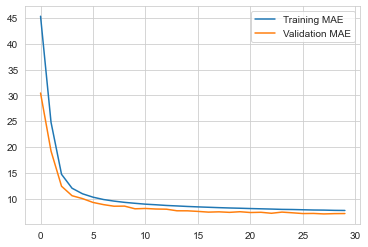

In [394]:
# Convert training history to a DataFrame.
df = pd.DataFrame(history_regr.history)

# Rename the relevant columns.
names = {'mae': 'Training MAE', 'val_mae': 'Validation MAE'}
df = df[['mae', 'val_mae']].rename(columns=names)

# Plot the results.
df.plot()

### Regression Results

Let us now compute some performance measures for the Neural Network. First we use the fitted model to predict the stock-returns for the training- and test-sets:

In [395]:
%%time
y_train_pred = model_regr.predict(X_train.values)
y_test_pred = model_regr.predict(X_test.values)

CPU times: user 22.9 s, sys: 2.03 s, total: 24.9 s
Wall time: 16.8 s


We can then calculate the $R^2$ value (aka. the coefficient of determination) between the actual stock-returns and those predicted by the model. A value of 1 means a perfect prediction, while a value of 0 means the model basically predicted the average stock-return, and a negative value means the model's prediction was worse than just using the average stock-return.

The $R^2$ value is about 0.5 for the training-set, which is OK but could be much higher if we trained it more, and if we used a bigger Neural Network with more parameters to optimize.

In [396]:
r2_score(y_true=y_train, y_pred=y_train_pred)

0.9661634073147048

But the $R^2$ value is very negative for the test-set, which is so bad, that it would be much better to just use the average stock-return. This shows the model has not learned the underlying relation between the signals X and stock-returns y. The model has merely learned noise or peculiarities in the training-data, which do not generalize to the unseen data in the test-set:

In [397]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.947637812530185

### The results are very good actually.
The $R^2$ value for training and test set are: 0.97,0.93, which is very good

### Regression Examples

We can also try and plot the model's predicted versus actual stock-returns for a stock in the training-set. As we can see, the model has learned this mapping reasonably well:

In [95]:
# ticker="A"

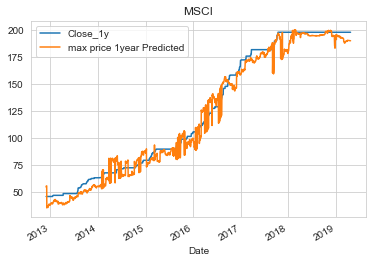

In [285]:
# Column-name for the models' predicted stock-returns.
price_1y_PRED = 'max price 1year Predicted'

# Create a DataFrame with actual and predicted stock-returns.
# This is for the training-set.
df_y_train = pd.DataFrame(y_train)
df_y_train[price_1y_PRED] = y_train_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[11]
_ = df_y_train.loc[ticker].plot(title=ticker)

Now let us try and plot the model's predicted versus actual stock-returns for the first stock in the test-set. As we can see, the model is mostly unable to predict the stock-returns, for this data that it has not seen during its training:

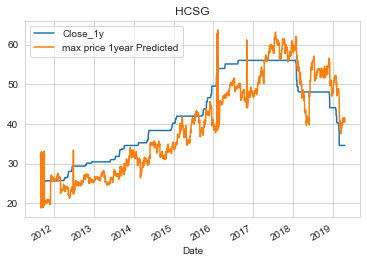

In [290]:
# Create a DataFrame with actual and predicted stock-returns.
# This is for the test-set.
df_y_test = pd.DataFrame(y_test)
df_y_test[price_1y_PRED] = y_test_pred

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[12]
_ = df_y_test.loc[ticker].plot(title=ticker)

## Save model to file

In [287]:
# https://stackoverflow.com/questions/67661244/how-to-pickle-weakref-in-python-tensorflow-keras?noredirect=1
filename = '/home/upsman/MLAI/simfin_my/models/year1maxPrice_model2.sav'
tf.keras.models.save_model(model_regr, filename)

INFO:tensorflow:Assets written to: /home/upsman/MLAI/simfin_my/models/year1maxPrice_model2.sav/assets


In [109]:
loaded_model = tf.keras.models.load_model('/home/upsman/MLAI/simfin_my/models/year1maxPrice_model2.sav')

In [117]:
loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
____________________________________________________

In [288]:
# https://stackoverflow.com/questions/67661244/how-to-pickle-weakref-in-python-tensorflow-keras?noredirect=1
model_regr.save('/home/upsman/MLAI/simfin_my/models/year1maxPrice_model2.h5')

In [116]:
from keras.models import load_model
loaded_model_h5 = load_model('/home/upsman/MLAI/simfin_my/models/year1maxPrice_model2.h5')
loaded_model_h5.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               5632      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 16,641
Trainable params: 16,641
Non-trainable params: 0
____________________________________________________

In [103]:
# https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
import pickle
# save the model to disk
filename = 'year1maxPrice_model.sav'
pickle.dump(model_regr, open(filename, 'wb'))

TypeError: cannot pickle 'weakref' object

In [102]:
import dill
import weakref
# dill.dumps(weakref.WeakKeyDictionary())
dill.dump(model_regr, open('year1maxPrice_model.pkl', 'wb'))

ModuleNotFoundError: No module named 'dill'

In [104]:
import joblib
filename = 'year1maxPrice_model.sav'
joblib.dump(model_regr, filename)

TypeError: cannot pickle 'weakref' object

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)

## Neural Network: Classification

Instead of mapping from signals X to a continuous variable y for the stock-return, we can try and map to discrete output-classes that indicate if the stock-return was a gain or loss. This is a so-called binary classification problem, and perhaps that is easier for the Neural Network.

### Convert Output Data

First we need to convert the stock-returns into 1 for gains and 0 for losses, and then split into training- and test-sets:

In [ ]:
# df_cls,df_sig_rets

In [ ]:
# %%time
# # Convert stock-returns to binary classes where loss=0 and gain=1
# # In the previous tutorial we just used the sign directly, but it
# # is easier in TensorFlow / Keras to use class-values of 0 and 1.
# df_cls = (np.sign(df_sig_rets[TOTAL_RETURN_1_3Y]) + 1) * 0.5

# # Split the classes into training- and test-sets.
# y_train_cls = df_cls.loc[tickers_train]
# y_test_cls = df_cls.loc[tickers_test]

In [129]:
%%time
# Convert stock-returns to binary classes where loss=0 and gain=1
# In the previous tutorial we just used the sign directly, but it
# is easier in TensorFlow / Keras to use class-values of 0 and 1.
# df_cls = (np.sign(df_all5['Close_1y']-df_all5['Close']) + 1) * 0.5

df_cls = df_all5['Close_1y']/df_all5['Close']
          
# Split the classes into training- and test-sets.
y_train_cls = df_cls.loc[tickers_train]
y_test_cls = df_cls.loc[tickers_test]

CPU times: user 80 ms, sys: 7.7 ms, total: 87.7 ms
Wall time: 85.2 ms


In [121]:
y_train_cls.shape,y_test_cls.shape,np.unique(df_cls)

((1823353,), (471223,), array([0. , 0.5, 1. ]))

In [122]:
df_all5['Close_1y'].describe()

count    2.294576e+06
mean     6.200766e+01
std      5.101066e+01
min      4.960000e+00
25%      2.373000e+01
50%      4.810000e+01
75%      8.413000e+01
max      1.983400e+02
Name: Close_1y, dtype: float64

In [130]:
df_cls.describe()

count    2.294576e+06
mean     1.469165e+00
std      7.326768e-01
min      2.279388e-01
25%      1.161833e+00
50%      1.341689e+00
75%      1.592467e+00
max      6.723390e+01
dtype: float64

In [ ]:
# #7 classes
# conditions = [
#     (df_sig_rets[TOTAL_RETURN_1_3Y] < (-0.4)),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>=(-0.4)) & (df_sig_rets[TOTAL_RETURN_1_3Y]<(-0.2)),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>=(-0.2)) & (df_sig_rets[TOTAL_RETURN_1_3Y]<(-0.1)),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>=(-0.1)) & (df_sig_rets[TOTAL_RETURN_1_3Y]<0.1),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>=0.1) & (df_sig_rets[TOTAL_RETURN_1_3Y]<0.2),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>=0.2) & (df_sig_rets[TOTAL_RETURN_1_3Y]<0.4),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>= 0.4)]
# choices = [0,1,2,3,4,5,6]
# df_sig_rets['return3y'] = np.select(conditions, choices)
# df_cls = df_sig_rets['return3y']
# #print(df_sig_rets)
# np.unique(df_cls)

In [ ]:
# #3 classes
# conditions = [
#     (df_sig_rets[TOTAL_RETURN_1_3Y] < (-0.2)),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>=(-0.2)) & (df_sig_rets[TOTAL_RETURN_1_3Y]<0.2),
#     (df_sig_rets[TOTAL_RETURN_1_3Y]>=0.2)]
# choices = [0,1,2]
# df_sig_rets['return3y'] = np.select(conditions, choices)
# df_cls = df_sig_rets['return3y']
# #print(df_sig_rets)
# np.unique(df_cls)

In [ ]:
#3 classes
conditions = [
    (df_sig_rets[TOTAL_RETURN_1_1Y] < (-0.1)),
    (df_sig_rets[TOTAL_RETURN_1_1Y]>=(-0.1)) & (df_sig_rets[TOTAL_RETURN_1_1Y]<0.2),
    (df_sig_rets[TOTAL_RETURN_1_1Y]>=0.2)]
choices = [0,1,2]
df_sig_rets['return1y'] = np.select(conditions, choices)
df_cls = df_sig_rets['return1y']
#print(df_sig_rets)
np.unique(df_cls)

In [139]:
#3 classes
conditions = [
    (df_cls < 1.16),
    ((df_cls>=1.16) & (df_cls<1.34)),
    (df_cls>=1.59)]
choices = [0,1,2]
df_all5['ratio1y'] = np.select(conditions, choices)
df_cls2 = df_all5['ratio1y']
#print(df_sig_rets)
np.unique(df_cls2)

array([0, 1, 2])

In [140]:
np.unique(np.select(conditions, choices))

array([0, 1, 2])

In [141]:
# Split the classes into training- and test-sets.
y_train_cls = df_cls2.loc[tickers_train]
y_test_cls = df_cls2.loc[tickers_test]

In [142]:
df_cls2

Ticker  Date      
A       2011-09-29    0
        2011-09-30    0
        2011-10-03    0
        2011-10-04    0
        2011-10-05    0
                     ..
ZUMZ    2019-04-15    1
        2019-04-16    1
        2019-04-17    0
        2019-04-18    1
        2019-04-22    0
Name: ratio1y, Length: 2294576, dtype: int64

In [ ]:
# np.unique(df_sig_rets['return3y']), np.unique(y_train_cls)

In [143]:
np.unique(df_all5['ratio1y'])

array([0, 1, 2])

In [ ]:
df_cls

In [153]:
y_train_cls

Ticker  Date      
FANG    2018-03-01    0
        2018-03-02    0
        2018-03-05    0
        2018-03-06    0
        2018-03-07    0
                     ..
LOGI    2019-04-15    2
        2019-04-16    2
        2019-04-17    2
        2019-04-18    2
        2019-04-22    2
Name: ratio1y, Length: 1823353, dtype: int64

Because this is a binary classification problem (the result is either a gain or a loss), we could build a Neural Network to use `y_train_cls` directly. But instead we want to build a more general type of Neural Network which supports any number of output classes. For this we must convert the output to so-called one-hot encoded arrays, so a class of 0 (loss) becomes the array `[1,0]` and a class of 1 (gain) becomes the array `[0,1]`.

In [ ]:
to_categorical?

In [154]:
# Convert classes to one-hot-encoded arrays.
y_train_one_hot = to_categorical(y=y_train_cls.values,
                                 num_classes=3)

# Show the result.
y_train_one_hot

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [155]:
y_train_cls.values

array([0, 0, 0, ..., 2, 2, 2])

The training-set is also biased because it contains many more samples with gains compared to losses:

In [128]:
# Fraction of the training-set that is classified as gains.
gain_fraction = (y_train_cls == 1.0).sum() / len(y_train_cls)
loss_fraction = 1.0 - gain_fraction

# Show it.
gain_fraction

0.9829884833052075

When we train the Neural Network further below, we need to provide new class-weights to counter this imbalance between the two classes:

In [ ]:
y_train_cls[y_train_cls==0]

In [ ]:
compute_class_weight?

In [145]:
# Calculate the class-weights.
class_weight = compute_class_weight('balanced',
                                    y=y_train_cls,
                                    classes=[0,1,2])

# Show them.
class_weight

array([0.66803802, 1.3233589 , 1.33792454])

We can check that when we multiply these weights by the class-fractions for losses and gains, they both end up with the same weights:

In [146]:
# class_weight * [loss_fraction, gain_fraction]

In [147]:
# The problem is that the sklearn API returns a numpy array but the keras requires a dictionary as an input for class_weight (see here). 
# https://stackoverflow.com/questions/61261907/on-colab-class-weight-is-causing-a-valueerror-the-truth-value-of-an-array-wit
class_weight=dict(enumerate(class_weight.flatten(), 0))

In [148]:
class_weight

{0: 0.6680380227997574, 1: 1.3233588954160986, 2: 1.3379245418697379}

### Build and Train Neural Network: Classification

Now that we have prepared the classification data, we can proceed to build the Neural Network. We will use the same overall design as for the regression model above, with minor changes for the classification task.

In [157]:
X_train

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
FANG   2018-03-01                          -0.309052       -1.260609   
       2018-03-02                          -0.309052       -1.260609   
       2018-03-05                          -0.309052       -1.260609   
       2018-03-06                          -0.309052       -1.260609   
       2018-03-07                          -0.309052       -1.260609   
...                                              ...             ...   
LOGI   2019-04-15                          -0.023059        0.509871   
       2019-04-16                          -0.023059        0.509871   
       2019-04-17                          -0.023059        0.509871   
       2019-04-18                          -0.023059        0.509871   
       2019-04-22                          -0.023059        0.509871   

                   CapEx / (Depr + Amor)  Current Ratio  Dividends / FCF  \
Ticker Date                                                                
FANG   2018-03-01               2.912428      -1.003317        -0.588742   
       2018-03-02               2.912428      -1.003317        -0.588742   
       2018-03-05               2.912428      -1.003317        -0.588742   
       2018-03-06               2.912428      -1.003317        -0.588742   
       2018-03-07               2.912428      -1.003317        -0.588742   
...                                  ...            ...              ...   
LOGI   2019-04-15              -0.556777      -0.399220         0.451337   
       2019-04-16              -0.556777      -0.399220         0.451337   
       2019-04-17              -0.556777      -0.399220         0.451337   
       2019-04-18              -0.556777      -0.399220         0.451337   
       2019-04-22              -0.556777      -0.399220         0.451337   

                   Gross Profit Margin  Interest Coverage  Log Revenue  \
Ticker Date                                                              
FANG   2018-03-01             1.926230           0.152730    -0.092128   
       2018-03-02             1.926230           0.152730    -0.092128   
       2018-03-05             1.926230           0.152730    -0.092128   
       2018-03-06             1.926230           0.152730    -0.092128   
       2018-03-07             1.926230           0.152730    -0.092128   
...                                ...                ...          ...   
LOGI   2019-04-15            -0.252042          -0.856118     0.343681   
       2019-04-16            -0.252042          -0.856118     0.343681   
       2019-04-17            -0.252042          -0.856118     0.343681   
       2019-04-18            -0.252042          -0.856118     0.343681   
       2019-04-22            -0.252042          -0.856118     0.343681   

                   Net Profit Margin  Quick Ratio  ...   P/Sales  \
Ticker Date                                        ...             
FANG   2018-03-01           1.240687    -0.734716  ...  2.729243   
       2018-03-02           1.240687    -0.734716  ...  2.806543   
       2018-03-05           1.240687    -0.734716  ...  2.840415   
       2018-03-06           1.240687    -0.734716  ...  2.748930   
       2018-03-07           1.240687    -0.734716  ...  2.725190   
...                              ...          ...  ...       ...   
LOGI   2019-04-15           0.318342    -0.230555  ... -0.027123   
       2019-04-16           0.318342    -0.230555  ... -0.020113   
       2019-04-17           0.318342    -0.230555  ... -0.018580   
       2019-04-18           0.318342    -0.230555  ... -0.019675   
       2019-04-22           0.318342    -0.230555  ... -0.019894   

                   Price to Book Value  SimFinId      Open       Low  \
Ticker Date                                                            
FANG   2018-03-01            -0.450265  1.427744  2.109512  2.127665   
       2018-03-02            

In [225]:
fit_args = \
{
    # For efficiency, the model is trained on batches of data.
    'batch_size': 4096,
    
    # Number of iterations aka. epochs over the training-set.
    'epochs': 20,
    
    # Fraction of the training-set used for validation after
    # each training-epoch, to assess how well the model performs
    # on unseen data.
    'validation_split': 0.2,

    # Show status during training.
    'verbose': 1,
}

In [151]:
# The activation function applied after each layer.
# It is important to use a non-linear function, otherwise
# the Neural Network cannot learn non-linear mappings.
activation = 'relu'
#activation = 'selu'

In [184]:
# Create a new Keras model.
model_clf = keras.Sequential()

# Add an input layer for the signals.
# Note how we set the dimensionality of the input here.
model_clf.add(InputLayer(input_shape=(num_signals,)))

# Add several dense aka. fully-connected layers.
# You can experiment with different designs.
model_clf.add(Dense(128, activation=activation))
model_clf.add(Dense(64, activation=activation))
model_clf.add(Dense(32, activation=activation))
model_clf.add(Dense(16, activation=activation))
model_clf.add(Dense(8, activation=activation))

# Add a layer for the output of the Neural Network.
# This has 2 outputs, one for each possible class, and it uses
# the softmax activation function for classification.
model_clf.add(Dense(3, activation='softmax'))

# Compile the model but don't train it yet.
# Note that it uses a different loss-function and metric
# than the regression-model above.
model_clf.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=RMSprop(0.001))

# Show the model.
model_clf.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               5632      
_________________________________________________________________
dense_27 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_28 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_29 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_31 (Dense)             (None, 3)                 27        
Total params: 16,659
Trainable params: 16,659
Non-trainable params: 0
__________________________________________________

In [226]:
# This model reaches 0.45-0.46 of validation accuracy at epoch=20, 0.47-0.48 at epoch=30~40

# Create a new Keras model.
model_clf = keras.Sequential()

# Add an input layer for the signals.
# Note how we set the dimensionality of the input here.
model_clf.add(InputLayer(input_shape=(num_signals,)))

#using LeakyReLU
from keras.layers import LeakyReLU
# here change your line to leave out an activation 
model_clf.add(Dense(128))
# now add a ReLU layer explicitly:
model_clf.add(LeakyReLU(alpha=0.05))
#model_clf.add(Dropout(0.2))

# add dropout helps
from keras.layers import Dropout
# Add several dense aka. fully-connected layers.
# You can experiment with different designs.
model_clf.add(Dense(128, activation=activation))
model_clf.add(Dropout(0.3))
model_clf.add(Dense(64, activation=activation))
model_clf.add(Dropout(0.3))
model_clf.add(Dense(32, activation=activation))
model_clf.add(Dropout(0.2))
model_clf.add(Dense(16, activation=activation))
model_clf.add(Dropout(0.2))
model_clf.add(Dense(8, activation=activation))
#model_clf.add(Dropout(0.2))

# Add a layer for the output of the Neural Network.
# This has 2 outputs, one for each possible class, and it uses
# the softmax activation function for classification.
model_clf.add(Dense(3, activation='softmax'))

# Compile the model but don't train it yet.
# Note that it uses a different loss-function and metric
# than the regression-model above.
model_clf.compile(loss='categorical_crossentropy',
                  metrics=['accuracy'],
                  optimizer=RMSprop(0.001))

# Show the model.
model_clf.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 128)               5632      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 32)               

We can now train the model. This takes a minute or two on an ordinary computer:

In [227]:
%%time
history_clf = model_clf.fit(x=X_train.values, y=y_train_one_hot,
                            class_weight=class_weight, **fit_args)

Epoch 1/20
357/357 [==============================] - 4s 10ms/step - loss: 0.9684 - accuracy: 0.4719 - val_loss: 0.9947 - val_accuracy: 0.4505
Epoch 2/20
357/357 [==============================] - 3s 9ms/step - loss: 0.8663 - accuracy: 0.5095 - val_loss: 1.0434 - val_accuracy: 0.4232
Epoch 3/20
357/357 [==============================] - 3s 9ms/step - loss: 0.8078 - accuracy: 0.5250 - val_loss: 1.0678 - val_accuracy: 0.4167
Epoch 4/20
357/357 [==============================] - 3s 9ms/step - loss: 0.7663 - accuracy: 0.5384 - val_loss: 1.1840 - val_accuracy: 0.4249
Epoch 5/20
357/357 [==============================] - 3s 9ms/step - loss: 0.7373 - accuracy: 0.5488 - val_loss: 1.1903 - val_accuracy: 0.4169
Epoch 6/20
357/357 [==============================] - 3s 9ms/step - loss: 0.7146 - accuracy: 0.5592 - val_loss: 1.1575 - val_accuracy: 0.4208
Epoch 7/20
357/357 [==============================] - 3s 9ms/step - loss: 0.6974 - accuracy: 0.5686 - val_loss: 1.1819 - val_accuracy: 0.4419
Epoch

We can then plot the training-progress as the classification accuracy which is supposed to be maximized. After 40 epochs through the training-set, the model has learned to map from signals to stock gain/loss for the training-set, with an accuracy of about 96% (this is not for the entire training-set, but only for one or more batches of data).

Unfortunately, the performance on the validation-set gets worse during optimization and ends with an accuracy of about 60%, so the model is clearly not learning the underlying relation between signals and stock gain/loss, but it has instead learned peculiarities and noise in the training-data.

<AxesSubplot:>

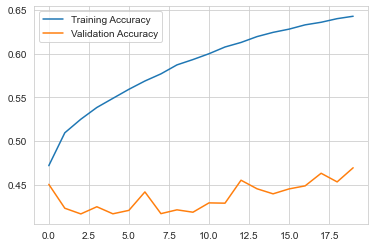

In [228]:
# Convert training history to a DataFrame.
df = pd.DataFrame(history_clf.history)

# Rename the relevant columns.
names = {'accuracy': 'Training Accuracy',
         'val_accuracy': 'Validation Accuracy'}
df = df[['accuracy', 'val_accuracy']].rename(columns=names)

# Plot the results.
df.plot()

In [229]:
history_clf

In [230]:
pd.DataFrame(history_clf.history)

,loss,accuracy,val_loss,val_accuracy
0,0.968380,0.471887,0.994651,0.450538
1,0.866315,0.509459,1.043437,0.423239
2,0.807820,0.524962,1.067770,0.416735
3,0.766253,0.538386,1.183983,0.424912
4,0.737285,0.548803,1.190289,0.416866
5,0.714589,0.559159,1.157493,0.420785
6,0.697362,0.568637,1.181883,0.441867
7,0.684361,0.576797,1.188470,0.417053
8,0.673067,0.587054,1.184148,0.421402
9,0.664334,0.593158,1.187991,0.418684


### Classification Results

We can then use the fitted model to predict the classes for the training- and test-sets:

In [231]:
%%time
y_train_pred_cls = model_clf.predict(X_train.values)
y_test_pred_cls = model_clf.predict(X_test.values)

CPU times: user 25.5 s, sys: 2.25 s, total: 27.8 s
Wall time: 18.8 s


The Neural Network has 2 outputs which is a likelihood score for each of the two classes:

In [232]:
y_test_pred_cls

array([[0.31808263, 0.1019096 , 0.58000773],
       [0.2464622 , 0.06945477, 0.68408304],
       [0.3081998 , 0.09748986, 0.59431034],
       ...,
       [0.41517124, 0.25773656, 0.32709223],
       [0.42421195, 0.2782479 , 0.2975401 ],
       [0.40650222, 0.24035294, 0.35314488]], dtype=float32)

In [233]:
np.argmax(y_test_pred_cls, axis=1)

array([2, 2, 2, ..., 0, 0, 0])

Let us convert this to a single integer class-number, by taking the so-called argmax, which is the index of the largest element in each row:

In [234]:
# Convert one-hot-encoded arrays to integer class-numbers.
y_train_pred_cls = y_train_pred_cls.argmax(axis=1)
y_test_pred_cls = y_test_pred_cls.argmax(axis=1)

# Show the result.
y_test_pred_cls

array([2, 2, 2, ..., 0, 0, 0])

In [235]:
np.unique(y_test_cls),np.unique(y_test_pred_cls),np.unique(y_train_one_hot)

(array([0, 1, 2]), array([0, 1, 2]), array([0., 1.], dtype=float32))

In [236]:
np.unique(y_test_pred_cls),np.unique(y_train_cls),np.unique(y_test_pred_cls)

(array([0, 1, 2]), array([0, 1, 2]), array([0, 1, 2]))

We can now calculate the classification accuracy for the entire training-set, which is almost 90%, so the model has learned to map financial signals to gain/loss classifications for 1-3 year investment periods:

In [237]:
accuracy_score(y_true=y_train_cls, y_pred=y_train_pred_cls)

0.6539271331442678

Unfortunately this performance does not generalize to the test-set, which the model has not seen during training. Here the classification accuracy is much lower:

In [238]:
accuracy_score(y_true=y_test_cls, y_pred=y_test_pred_cls)

0.4552664025312856

This is even worse than simply guessing that the stock-returns are always gains, which would give a classification accuracy of about 70%:

In [239]:
# Fraction of the test-set that is classified as gains.
(y_test_cls == 2).sum() / len(y_test_cls)

0.25973477525502786

### Confusion Matrix

We can also plot a so-called Confusion Matrix, which shows how well the classes were predicted. First we need a small helper-function for making the plot:

In [203]:
# def plot_confusion_matrix(y_true, y_pred):
#     """
#     Plot a classification confusion matrix.
    
#     :param y_true: Array of true classes.
#     :param y_pred: Array of predicted classes.
#     """
    
#     # Class labels.
#     labels = [1.0, 0.0]
#     labels_text = ['Gain', 'Loss']

#     # Create confusion matrix.
#     mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
#                            labels=labels)
    
#     # Normalize so all matrix entries sum to 1.0
#     mat = mat / len(y_true)
    
#     # Plot the matrix as a heatmap.
#     sns.heatmap(mat, robust=True,
#                 xticklabels=labels_text,
#                 yticklabels=labels_text)

In [204]:
# # we now have 5 classes
# def plot_confusion_matrix(y_true, y_pred):
#     """
#     Plot a classification confusion matrix.
    
#     :param y_true: Array of true classes.
#     :param y_pred: Array of predicted classes.
#     """
    
#     # Class labels.
#     labels = [0,1,2,3,4,5,6]
#     labels_text = ['bigerloss','bigloss', 'Loss','nochange',"gain","biggain","biggergain"]

#     # Create confusion matrix.
#     mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
#                            labels=labels)
    
#     # Normalize so all matrix entries sum to 1.0
#     mat = mat / len(y_true)
    
#     # Plot the matrix as a heatmap.
#     sns.heatmap(mat, robust=True,
#                 xticklabels=labels_text,
#                 yticklabels=labels_text)

In [240]:
#  3 classes
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a classification confusion matrix.
    
    :param y_true: Array of true classes.
    :param y_pred: Array of predicted classes.
    """
    
    # Class labels.
    labels = [0,1,2]
    labels_text = ['Loss','modest_gain',"high_gain"]

    # Create confusion matrix.
    mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
                           labels=labels)
    
    # Normalize so all matrix entries sum to 1.0
    mat = mat / len(y_true)
    
    # Plot the matrix as a heatmap.
    sns.heatmap(mat, robust=True,
                xticklabels=labels_text,
                yticklabels=labels_text)

For the training-set, we again see that the model has learned to accurately classify gains and losses. Note how the colours are different, because the training-set contains many more gains than losses.

In [241]:
y_train_cls,y_train_pred_cls

(Ticker  Date      
 FANG    2018-03-01    0
         2018-03-02    0
         2018-03-05    0
         2018-03-06    0
         2018-03-07    0
                      ..
 LOGI    2019-04-15    2
         2019-04-16    2
         2019-04-17    2
         2019-04-18    2
         2019-04-22    2
 Name: ratio1y, Length: 1823353, dtype: int64,
 array([0, 0, 0, ..., 1, 1, 1]))

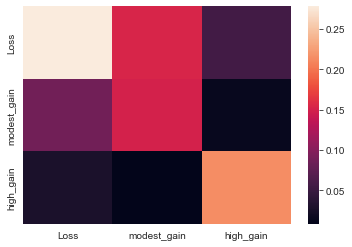

In [242]:
plot_confusion_matrix(y_true=y_train_cls, y_pred=y_train_pred_cls)

The confusion matrix for the test-set, shows that many classes were correctly predicted as gains, and there were a lot of errors in the rest of the predictions:

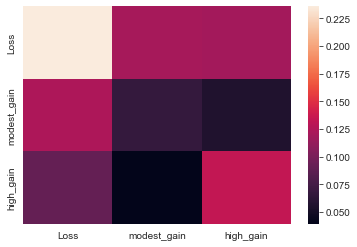

In [243]:
plot_confusion_matrix(y_true=y_test_cls, y_pred=y_test_pred_cls)

### Classification Examples

We can also try and plot the model's predicted versus actual gain/loss classification for a stock in the training-set. As we can see, the model has learned this mapping quite well:

In [209]:
stock_index=np.where(tickers_train=='IBM')
print(stock_index)

(array([], dtype=int64),)


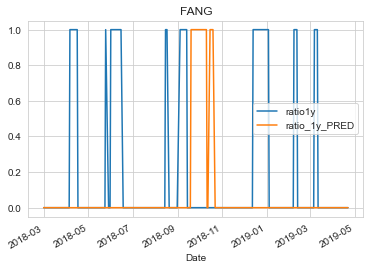

In [212]:
# Create a DataFrame with actual and predicted classifications.
# This is for the training-set.
df_y_train_cls = pd.DataFrame(y_train_cls)
df_y_train_cls['ratio_1y_PRED'] = y_train_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_train[0]
_ = df_y_train_cls.loc[ticker].plot(title=ticker)

In [213]:
df_y_train_cls.loc[ticker]

,ratio1y,ratio_1y_PRED
Date,,
2018-03-01,0,0
2018-03-02,0,0
2018-03-05,0,0
2018-03-06,0,0
2018-03-07,0,0
...,...,...
2019-04-15,0,0
2019-04-16,0,0
2019-04-17,0,0


Now let us try and plot the model's predicted versus actual gain/loss classifications for the first stock in the test-set. As we can see, the model is quite bad at predicting this for data that it has not seen during its training:

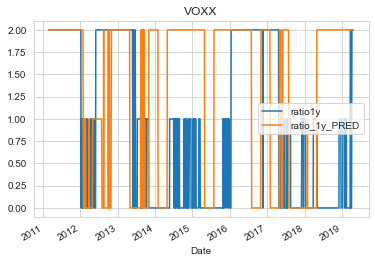

In [222]:
# Create a DataFrame with actual and predicted classifications.
# This is for the test-set.
df_y_test_cls = pd.DataFrame(y_test_cls)
df_y_test_cls['ratio_1y_PRED'] = y_test_pred_cls

# Plot the actual and predicted stock-returns for the first stock.
ticker = tickers_test[11]
_ = df_y_test_cls.loc[ticker].plot(title=ticker)

In [223]:
df_y_test_cls.loc[ticker]

,ratio1y,ratio_1y_PRED
Date,,
2011-02-28,2,2
2011-03-01,2,2
2011-03-02,2,2
2011-03-03,2,2
2011-03-04,2,2
...,...,...
2019-04-15,2,2
2019-04-16,2,2
2019-04-17,2,2


In [224]:
# accuracy_score for one stock only
accuracy_score(y_true=df_y_test_cls.loc[ticker]['ratio1y'], y_pred=df_y_test_cls.loc[ticker]['ratio_1y_PRED'])

0.44341463414634147

## Discussion

We used a Neural Network to learn the relation between signals and future stock-returns. This worked reasonably well on the training-data, but it did not generalize to the test-data, where the Neural Network performed worse than just guessing. In fact, the result was even worse than the previous tutorial which used a Machine Learning (ML) model called a Random Forest.

The problem might be the design of the Neural Network, that is, the number and size of the layers, their activation functions, etc. You can try and use so-called Hyper-Parameter Optimization such as the [Keras Tuner](https://keras-team.github.io/keras-tuner/), to try and find a better design for the Neural Network.

But we have now seen two very different ML models having the same problem with this dataset, so perhaps **it means that these financial signals simply cannot be used to predict future stock-returns for 1-3 year investment periods.**


### Machine Learning vs. Good Science

In the previous tutorial, we had a brief discussion about Machine Learning versus Good Science. We made an important point that is worth repeating here.

In general, these experiments show that Machine Learning cannot replace good science. *Even if the ML model had performed well on the test-data, it would not have provided an explanation for the underlying relation between signals and stock-returns, so we would not know whether it was truly something that would work in the future. To explain this we need proper scientific reasoning.*

A good example of scientific reasoning is the discovery and formulation of the Law of Gravity. A simple experiment would be to drop various items from different heights and take lots of measurements of how fast the items fall to the ground.

You can then make a noisy scatter-plot that shows the relation between item-size, item-weight, drop-height, and drop-speed. Statistical analysis would be able to give you a rough idea whether there is some relation in the data and if it is statistically significant, so the observed data is probably not just due to random chance. 

Machine Learning takes this one step further, in that it might be able to create a mathematical or computational model for the non-linear relation in the data, so you could use the ML model to predict the drop-speed if you input the other data. **But the ML model would not be able to explain *why* this relation exists in the data.** For this we need a proper theoretical framework such as Classical Mechanics in the case of the Law of Gravity.


### Predicting Long-Term Stock Returns

When it comes to predicting long-term stock-returns, there are actually only 3 factors that matter: <font color='red'> **The future dividends, sales-growth, and change in the P/Sales valuation ratio.** </font>(You could instead use earnings-growth or book-value growth, and the P/E or P/Book valuation ratios.) If we can predict the future dividend, sales-growth and P/Sales ratio, then we can predict the future stock-return.

When making scatter-plots of historical P/Sales ratios versus long-term stock-returns, we often see a particular downwards-sloping curve, and it turns out there is a certain formula for this curve, which is derived from the mathematical definition of Annualized Return, see [here](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb). The formula takes as input the average dividend yield, sales-growth and P/Sales ratios that you predict for the future, and produces a curve that can be used to predict future stock-returns from these 3 factors and the P/Sales ratio today. The accuracy of the prediction depends on how well you have predicted these 3 factors.

Machine Learning cannot uncover and explain such relations, whether it is the Law of Gravity, or the formula for long-term stock-returns. Human reasoning is still needed for this.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
